# Development and Testing Notebook

## Strategy Development

### Available data

In [ ]:
import os
from pathlib import Path
import options_wizard as ow
from dotenv import load_dotenv
load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir(): 
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

n_const = 25
suffix = 'cal_spread'
start_date = ow.DateObj(2010, 1, 1)
end_date = ow.DateObj(2025, 12, 31)
save_type = ow.SaveType.PICKLE

universe = ow.Universe()
universe.top_constituents(n_const)


In [2]:
delta_tol = 0.02
call_short_targ = 0.5
call_long_targ = 0.5
put_short_targ = 0.5
put_long_targ = 0.5


# --- ATM leg spec ---
front_put = ow.OptionsTradeSpec(
    call_put=ow.OptionType.PUT,
    ttm=lambda t: (t <= 30) ,
    strike=lambda k: True,
    abs_delta=lambda d: (abs(d) >= put_short_targ - delta_tol) and (abs(d) <= put_short_targ + delta_tol),
    entry_col=["days_to_next_earnings", "is_consolidating", "raw_underlying_close"],
    entry_cond=[lambda e: e == 5, lambda b: b == True, lambda r: (r >= 20) & (r <= 60)],
    exit_col="days_since_last_earnings",
    exit_cond=lambda e: (e >= 5) and (e <= 15),
    entry_min="perc_spread",
    volume_min=100,
    open_interest_min=100,
    max_hold_period=2,
    position = -1.0
)

front_call = ow.OptionsTradeSpec(
    call_put=ow.OptionType.CALL,
    ttm=lambda t: (t <= 30) ,
    strike=lambda k: True,
    abs_delta=lambda d: (abs(d) >= call_short_targ - delta_tol) and (abs(d) <= call_short_targ + delta_tol),
    entry_col=["days_to_next_earnings", "is_consolidating"],
    entry_cond=[lambda e: e == 5, lambda b: b == True],
    exit_col="days_since_last_earnings",
    exit_cond=lambda e: (e >= 15) and (e <= 20),
    entry_min="perc_spread",
    max_hold_period=2,
    volume_min=100,
    open_interest_min=100,
    position = -1.0
)

back_put = ow.OptionsTradeSpec(
    call_put=ow.OptionType.PUT,
    ttm=lambda t: (t >= 90) and (t <= 120),
    strike=lambda k: True,
    abs_delta=lambda d: (abs(d) >= put_long_targ - delta_tol) and (abs(d) <= put_long_targ + delta_tol),
    entry_col=["days_to_next_earnings", "is_consolidating"],
    entry_cond=[lambda e: e == 5, lambda b: b == True],
    entry_min="perc_spread",
    exit_col="days_since_last_earnings",
    exit_cond=lambda e: (e >= 15) and (e <= 20),
    max_hold_period=30,
    volume_min=100,
    open_interest_min=100,
    position = 1.0
)

back_call = ow.OptionsTradeSpec(
    call_put=ow.OptionType.CALL,
    ttm=lambda t: (t >= 90) and (t <= 120),
    strike=lambda k: True,
    abs_delta=lambda d: (abs(d) >= call_long_targ - delta_tol) and (abs(d) <= call_long_targ + delta_tol),
    entry_col=["days_to_next_earnings", "is_consolidating"],
    entry_cond=[lambda e: e == 5, lambda b: b == True],
    entry_min="perc_spread",
    max_hold_period=30,
    exit_col="days_since_last_earnings",
    exit_cond=lambda e: (e >= 15) and (e <= 20),
    volume_min=100,
    open_interest_min=100,
    position = 1.0
)

specs = [back_put, back_call]

In [3]:
from operator import le

pipeline = ow.Pipeline(universe=universe, save_type=save_type, saves = [ow.SaveFrames.STRAT])
kwargs = {
    'max_date': end_date.to_pl(),
    'keep_col' : ['ttm', 'n_missing'],
    'keep_oper': [le, le],
    'keep_val': [180, 0],
    'specs': specs,
    'hold_period': 30,
    'protected_notional': 1_000_000,
    'n_const': n_const,
    'other_data': ['recent_high_low'],
    'suffix': suffix
    }   

In [4]:
ow.add_cal_spread_methods(pipeline, kwargs)
pipeline.run()

  9%|▊         | 6/70 [01:45<14:07, 13.24s/it]$GENZ: possibly delisted; no price data found  (1d 2010-01-04 -> 2011-04-08)


Error executing function 'underlying_close_wrapped' for tick 'VIAB': Can only use .dt accessor with datetimelike values


 10%|█         | 7/70 [01:45<09:24,  8.97s/it]

Error executing function 'underlying_close_wrapped' for tick 'GENZ': Can only use .dt accessor with datetimelike values


 13%|█▎        | 9/70 [02:07<09:12,  9.05s/it]

Error executing function 'underlying_close_wrapped' for tick 'KRFT': Can only use .dt accessor with datetimelike values


 21%|██▏       | 15/70 [04:40<22:25, 24.46s/it]

Error executing function 'filter_gaps_wrapped' for tick 'TFCFA': The system cannot find the file specified. (os error 2): S:\Trading\NSA\Christoph\Option Data\Single Stocks\TFCFA.parquet

This error occurred with the following context stack:
	[1] 'parquet scan'
	[2] 'filter'
	[3] 'with_columns'
	[4] 'sink'



 31%|███▏      | 22/70 [08:50<22:24, 28.00s/it]

Error executing function 'underlying_close_wrapped' for tick 'SHPG': Could not convert '0.0819 USD' with type str: tried to convert to int64


 39%|███▊      | 27/70 [10:52<16:15, 22.69s/it]

Error executing function 'filter_gaps_wrapped' for tick 'TFCF': The system cannot find the file specified. (os error 2): S:\Trading\NSA\Christoph\Option Data\Single Stocks\TFCF.parquet

This error occurred with the following context stack:
	[1] 'parquet scan'
	[2] 'filter'
	[3] 'with_columns'
	[4] 'sink'



 53%|█████▎    | 37/70 [14:25<08:30, 15.48s/it]

Error executing function 'underlying_close_wrapped' for tick 'CMCSK': Can only use .dt accessor with datetimelike values


 60%|██████    | 42/70 [15:33<05:12, 11.15s/it]

Error executing function 'underlying_close_wrapped' for tick 'CELG': Can only use .dt accessor with datetimelike values


 70%|███████   | 49/70 [17:21<04:15, 12.19s/it]

Error executing function 'earnings_dates_wrapped' for tick 'ESRX': 'NoneType' object has no attribute 'sort_index'


 86%|████████▌ | 60/70 [23:14<03:31, 21.19s/it]

Error executing function 'underlying_close_wrapped' for tick 'BRCM': Can only use .dt accessor with datetimelike values


 89%|████████▊ | 62/70 [23:45<02:16, 17.08s/it]

Error executing function 'underlying_close_wrapped' for tick 'SPLS': Can only use .dt accessor with datetimelike values


 97%|█████████▋| 68/70 [27:28<00:58, 29.01s/it]

Error executing function 'underlying_close_wrapped' for tick 'WBA': Can only use .dt accessor with datetimelike values


100%|██████████| 70/70 [28:26<00:00, 24.38s/it]


## Backtesting the Strategy

### Building trades from outputs

In [5]:
import options_wizard as ow
from functools import partial

start_cash = 1_000_000


ptf = partial(
    ow.Trade,
    transaction_cost_model=ow.TransactionCostModel.SPREAD,
    accounting_type=ow.AccountingConvention.CASH
)
cfg = ow.BackTestConfig(
    starting_cash = start_cash,
    start_date=start_date,
    end_date=end_date,
    kwargs=kwargs
)
position = ow.SpreadFilteredTrade(cfg)

count = 0
for tick in universe.ticks:
    try:
        strat = ow.StratType.load(tick, save_type=save_type, suffix=suffix)  
        trades = strat.reconstruct(ptf)
        position.add_trade(trades)
    except FileNotFoundError:
        count += 1
        print(f"\rData for {tick} not found, skipping. Missing {count / len(universe.ticks):.2%} ", end=' '*12)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


### Running the Backtest

In [6]:
result = ow.BackTestCoordinator(
    position = position,
    dates = ow.market_dates(start_date, end_date, exchange=ow.Exchange.NASDAQ),
    debug = True
).run()

  0%|          | 19/4024 [00:00<00:00, 4748.93it/s]

Option(bid=0.3072870939420544, ask=0.35118525021949076, volume=45.56, date=DateObj(year=2010, month=2, day=1), tick='ADP', option_type=<OptionType.CALL: 'c'>, strike=36.87445127304653, expiry=DateObj(year=2010, month=2, day=20), iv=0.20155, underlying=Spot(bid=31.65754631384095, ask=31.65754631384095, volume=0.0, date=DateObj(year=2010, month=2, day=1), tick='ADP', underlying_type=<UnderlyingType.SPOT: 'Spot'>), num_underlying=113.9, rfr=None, delta=0.3108, gamma=0.1922, vega=0.0339, theta=-0.0167, rho=0.0058, other=None, underlying_type=<UnderlyingType.OPTION: 'Option'>)


AttributeError: 'NoneType' object has no attribute 'get'

Text(0, 0.5, 'Number of Open Trades')

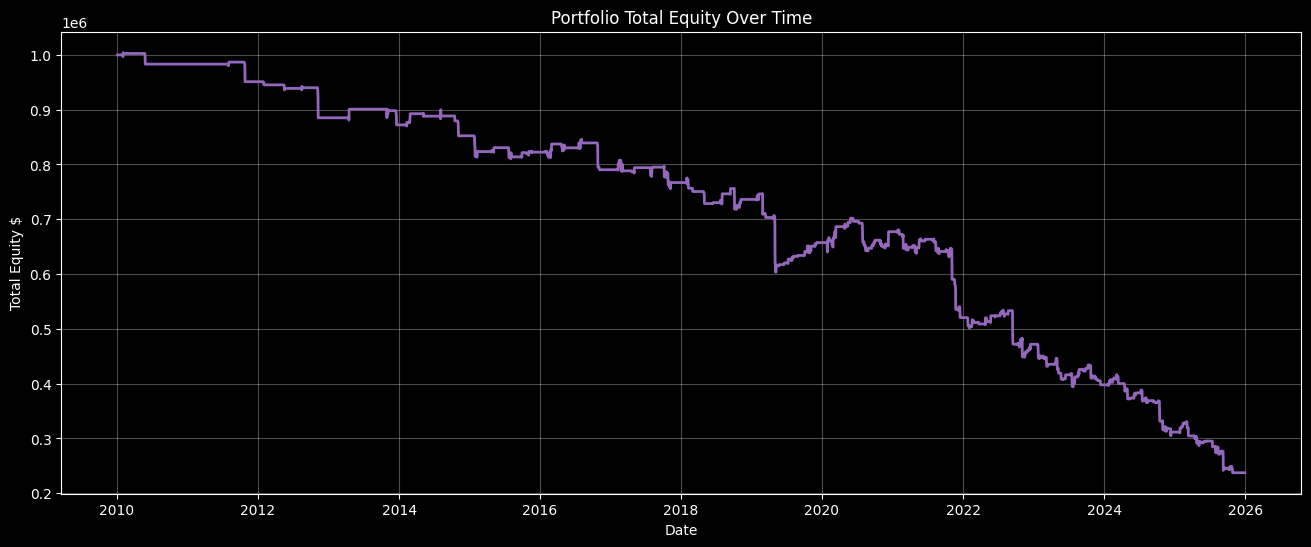

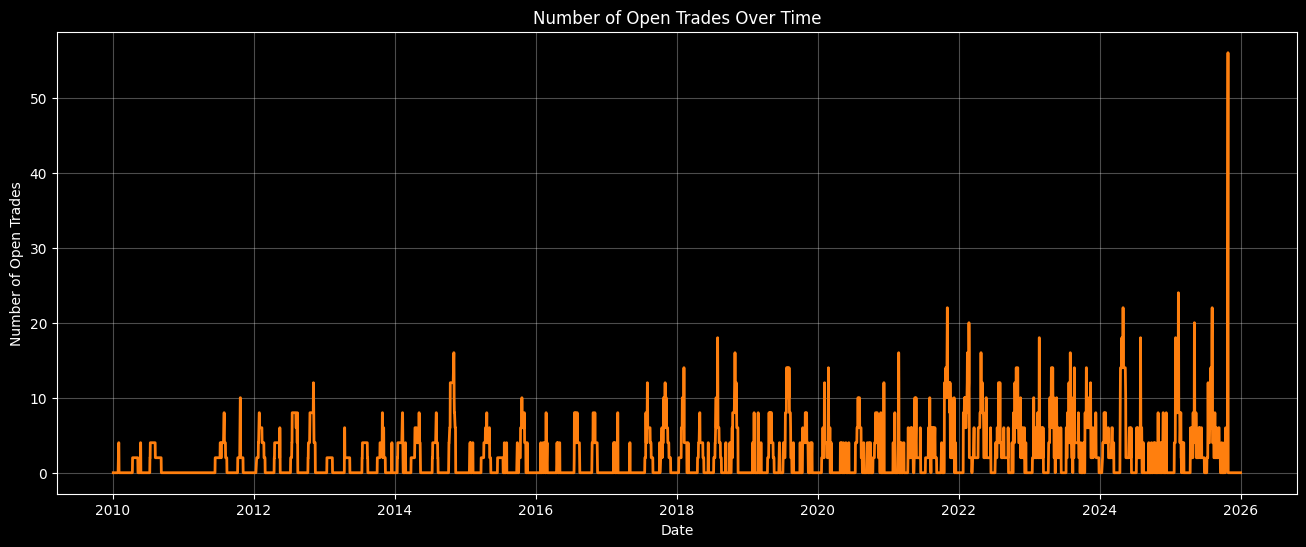

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotx 
import numpy as np
from statistics import mean

mpl.style.use("dark_background")

equity = np.array([snap.total_equity + snap.total_cash for snap in result.snapshots])
n_trades = np.array([len([key for key in snap.trade_equities.keys()]) for snap in result.snapshots])

dates = np.array([snap.date.to_datetime() for snap in result.snapshots])

fig2, ax2 = plt.subplots(figsize=(16, 6))
ax2.plot(dates, equity, color="tab:purple", lw=2, label="Total Equity")
ax2.grid(True, alpha=0.3)
ax2.set_title("Portfolio Total Equity Over Time")
ax2.set_xlabel("Date")
ax2.set_ylabel("Total Equity $")

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(dates, n_trades, color="tab:orange", lw=2, label="Number of Open Trades")
ax.grid(True, alpha=0.3)
ax.set_title("Number of Open Trades Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Open Trades")  

In [ ]:
[i.entry_data for i in (result.snapshots[2301].trade_equities.keys())]


[EntryData(entry_date=DateObj(year=2019, month=2, day=26), position_type=<PositionType.SHORT: 'short'>, price_series=PriceSeries(tick='BKNG', prices={'2019-02-26': Option(bid=26.1, ask=29.0, volume=24.0, date=DateObj(year=2019, month=2, day=26), tick='BKNG', option_type=<OptionType.CALL: 'c'>, strike=2000.0, expiry=DateObj(year=2019, month=3, day=15), iv=0.3539, underlying=Spot(bid=1915.72998046875, ask=1915.72998046875, volume=0.0, date=DateObj(year=2019, month=2, day=26), tick='BKNG', underlying_type=<UnderlyingType.SPOT: 'Spot'>), num_underlying=100.0, rfr=None, delta=0.3098, gamma=0.0024, vega=1.4642, theta=-1.5983, rho=0.2633, underlying_type=<UnderlyingType.OPTION: 'Option'>), '2019-02-27': Option(bid=19.5, ask=22.4, volume=67.0, date=DateObj(year=2019, month=2, day=27), tick='BKNG', option_type=<OptionType.CALL: 'c'>, strike=2000.0, expiry=DateObj(year=2019, month=3, day=15), iv=0.33485, underlying=Spot(bid=1906.0, ask=1906.0, volume=0.0, date=DateObj(year=2019, month=2, day=27)

C:\Users\cameronA\AppData\Local\Temp\ipykernel_40732\3139008102.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(16, 6))


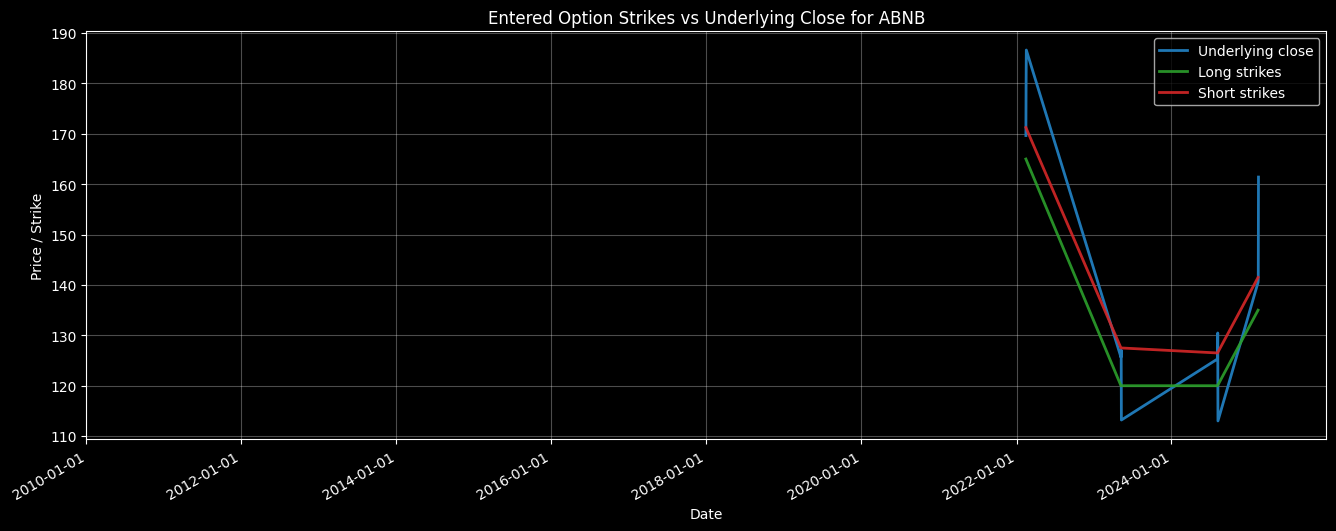

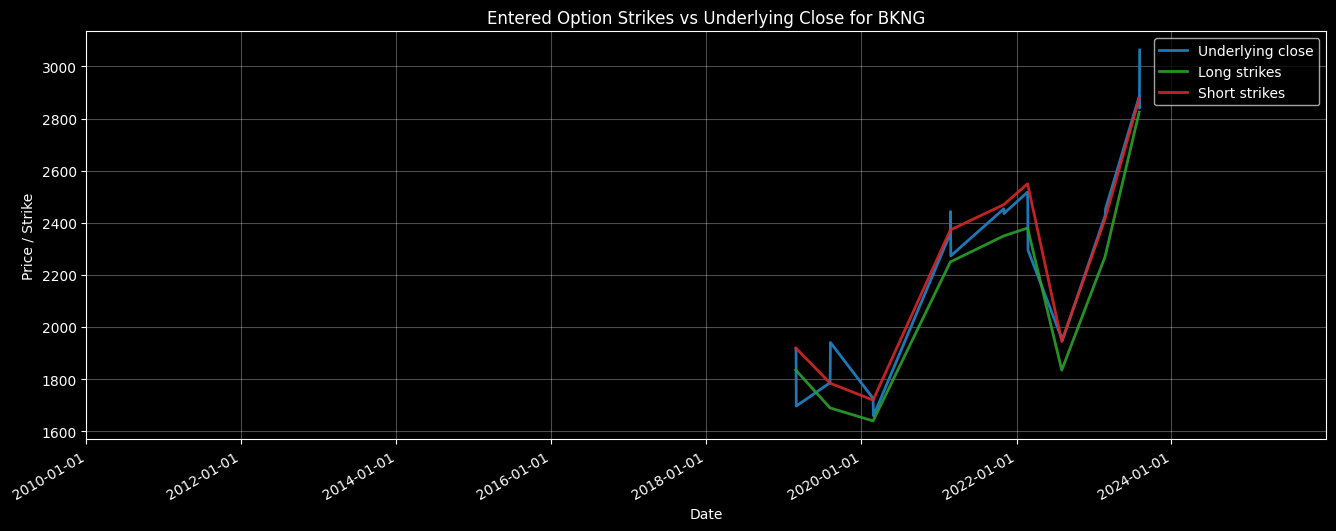

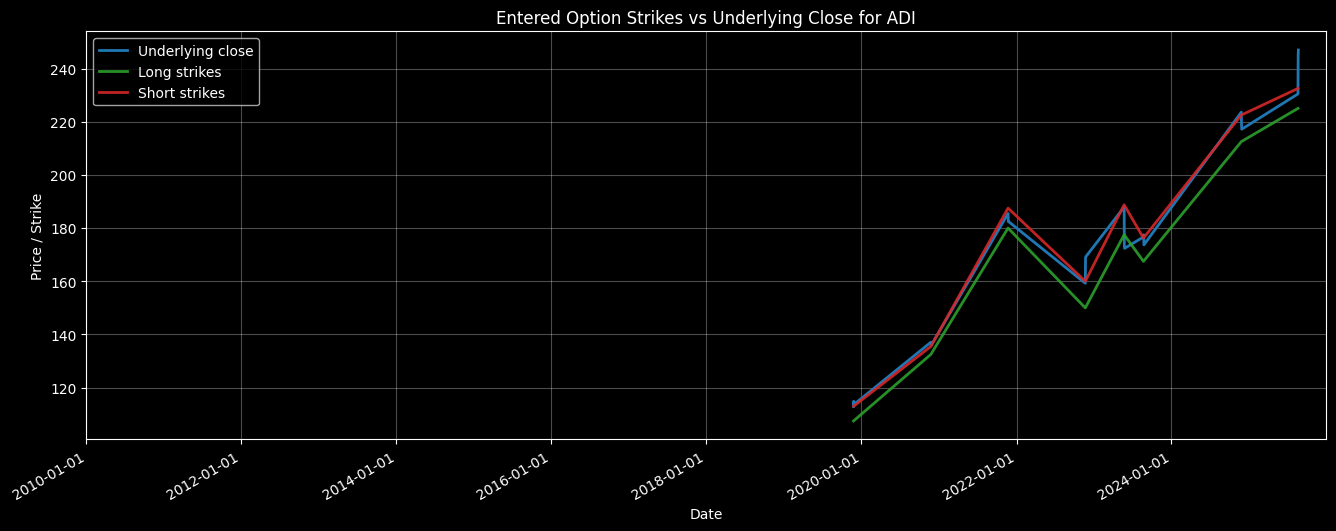

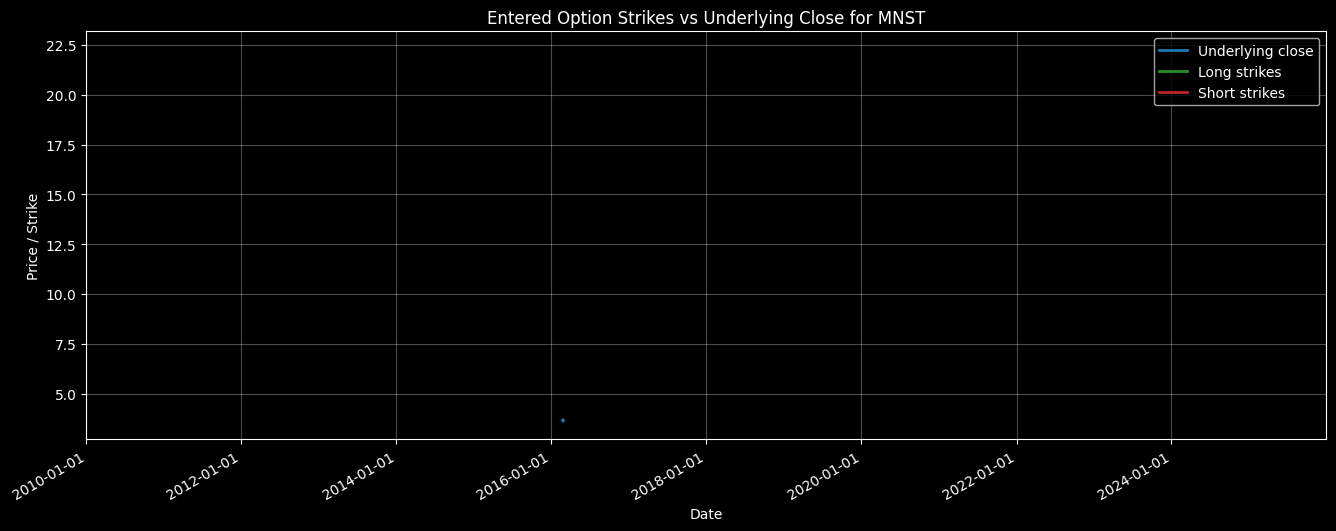

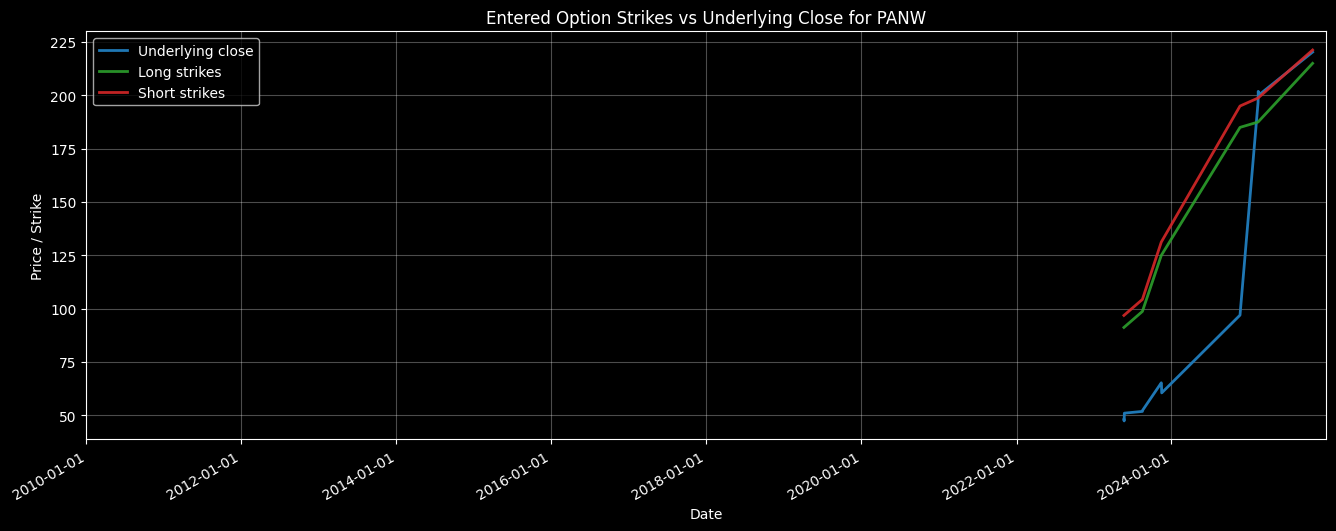

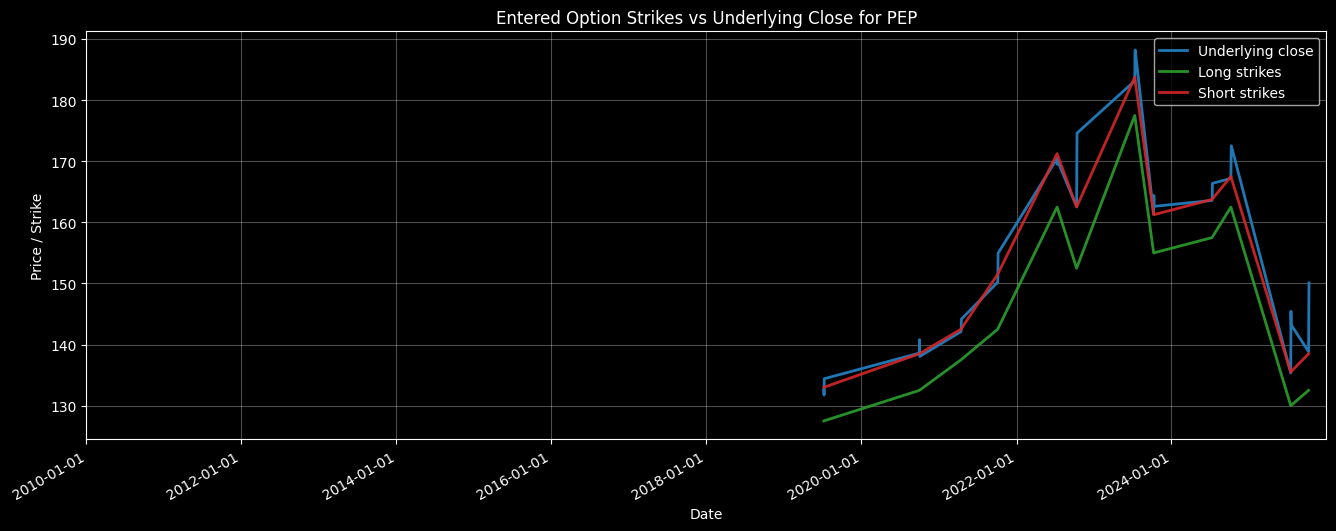

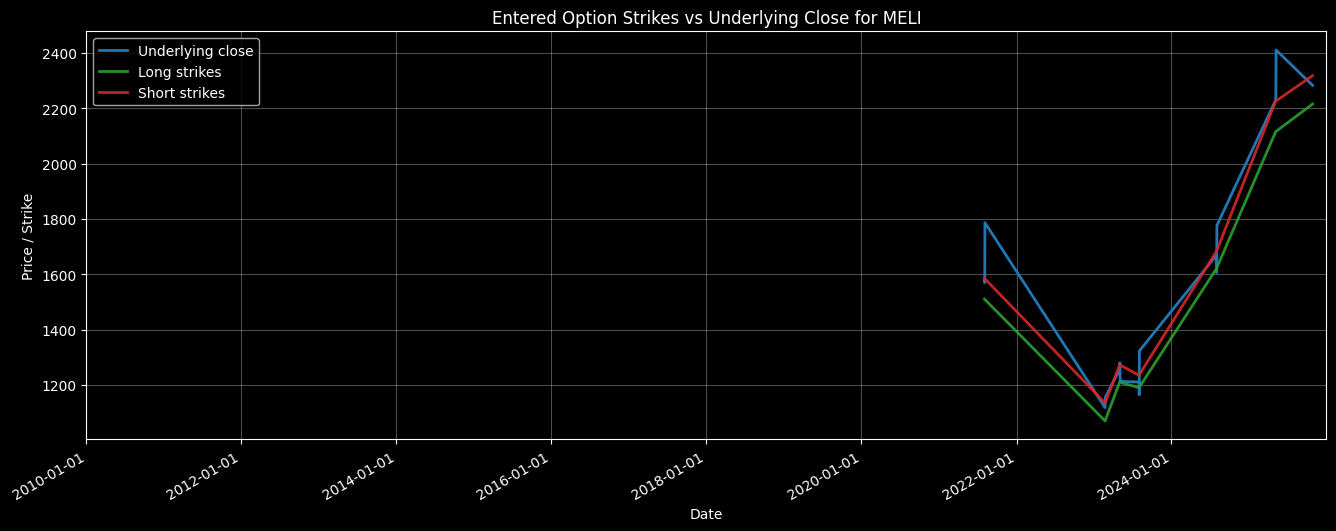

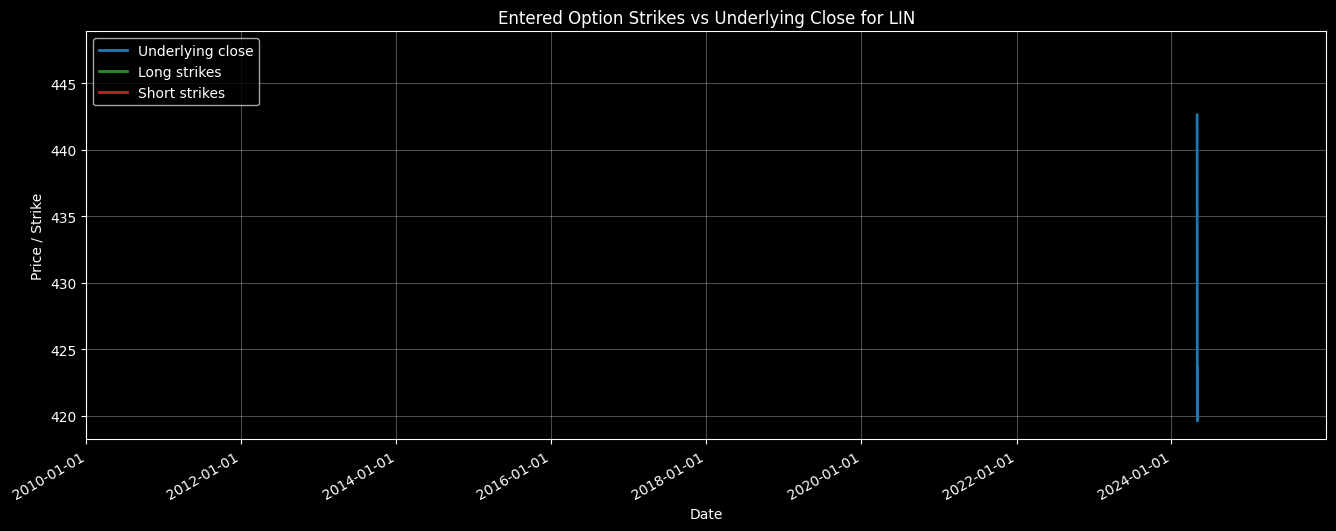

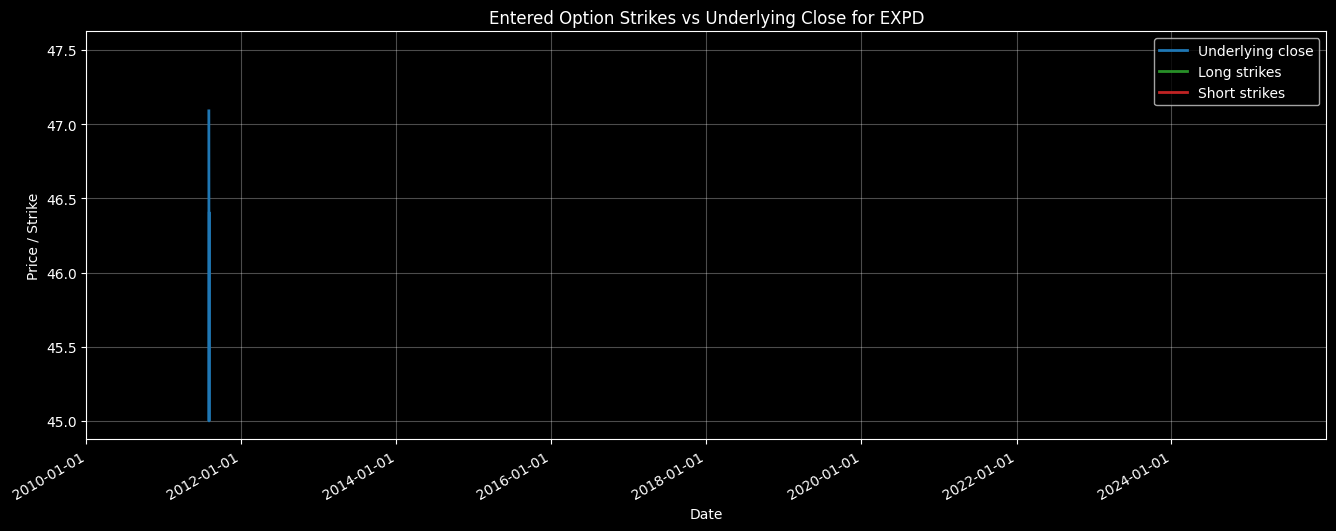

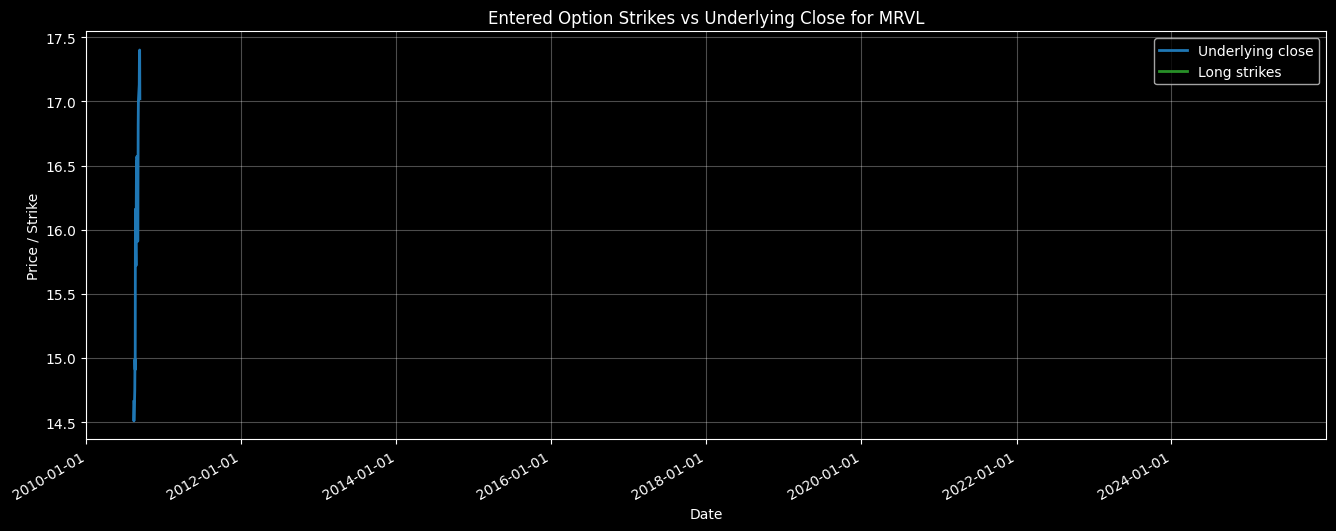

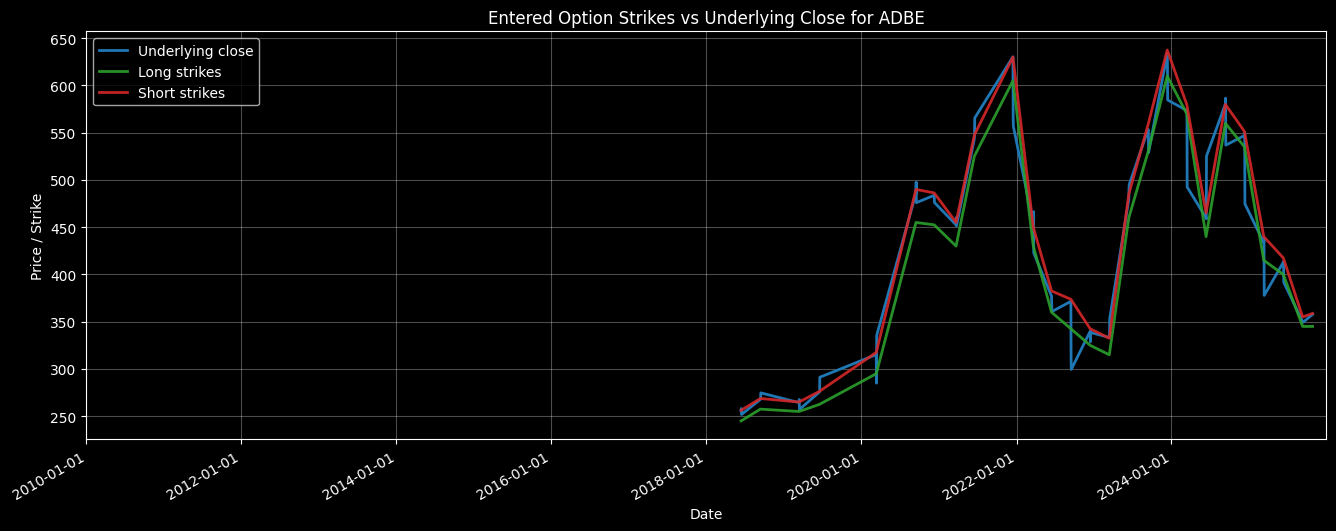

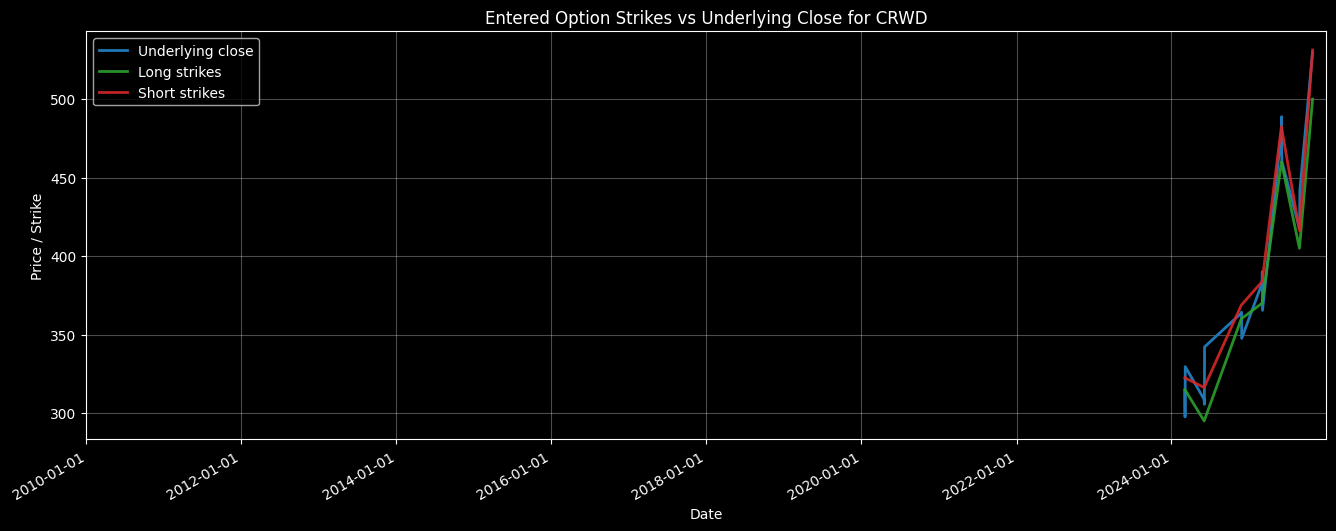

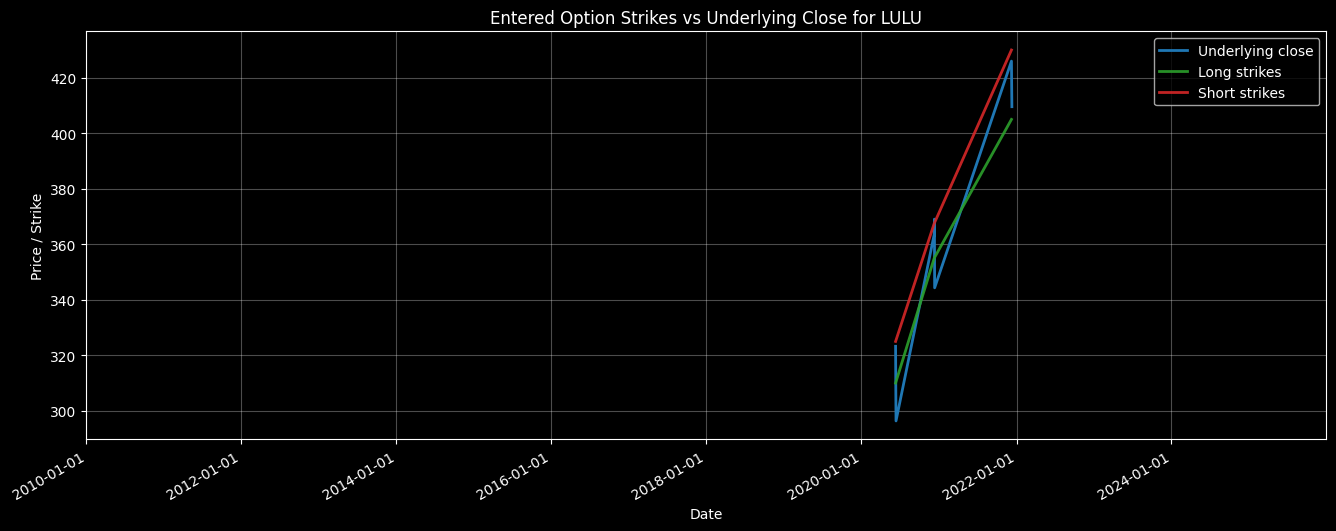

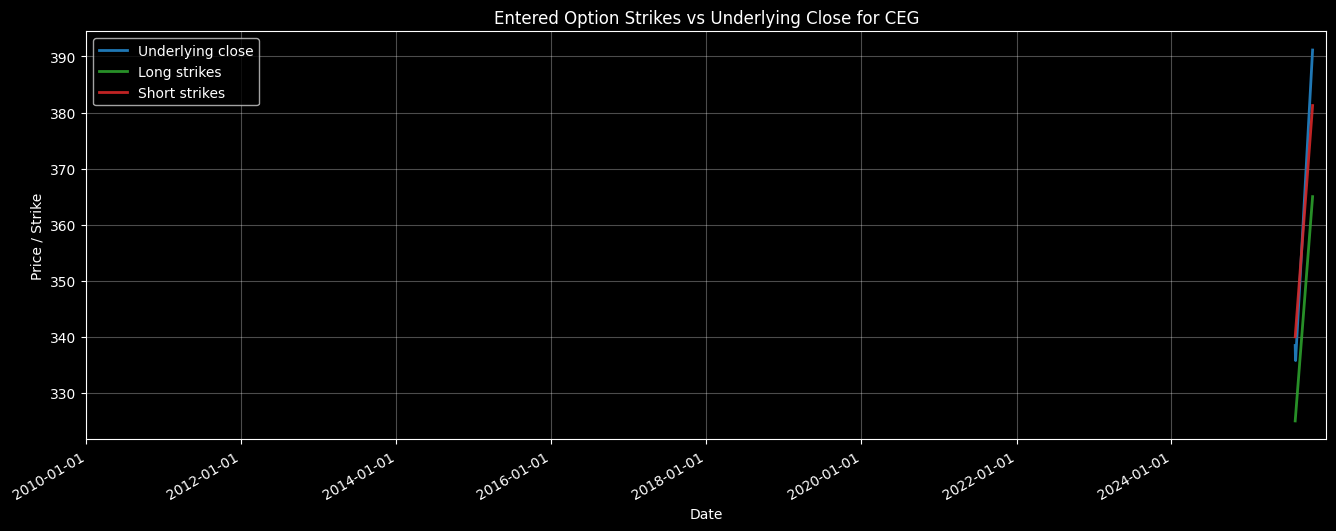

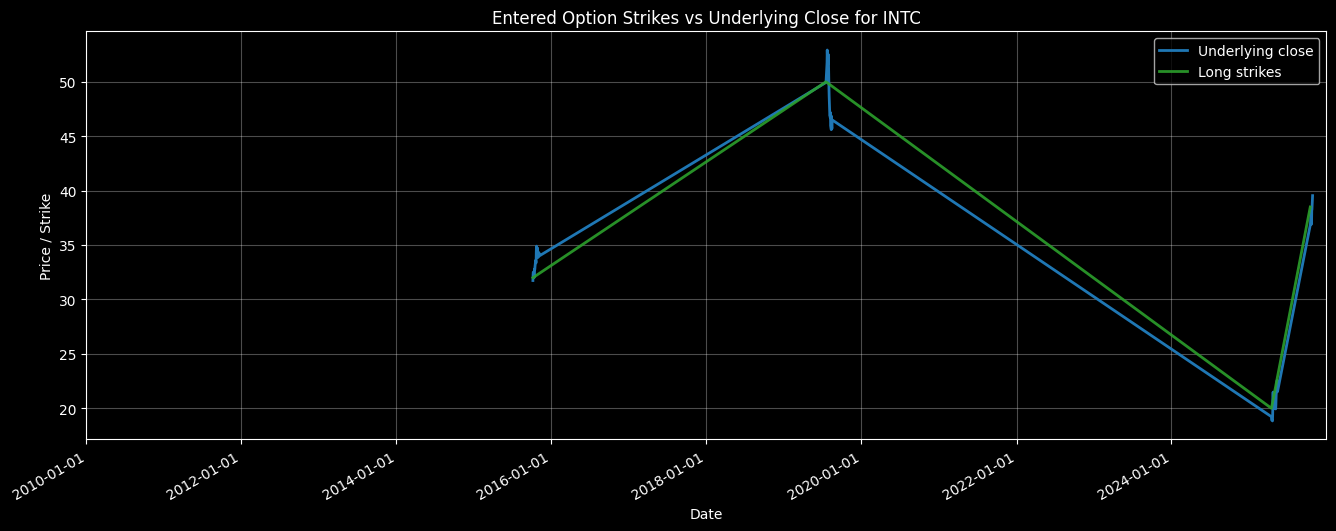

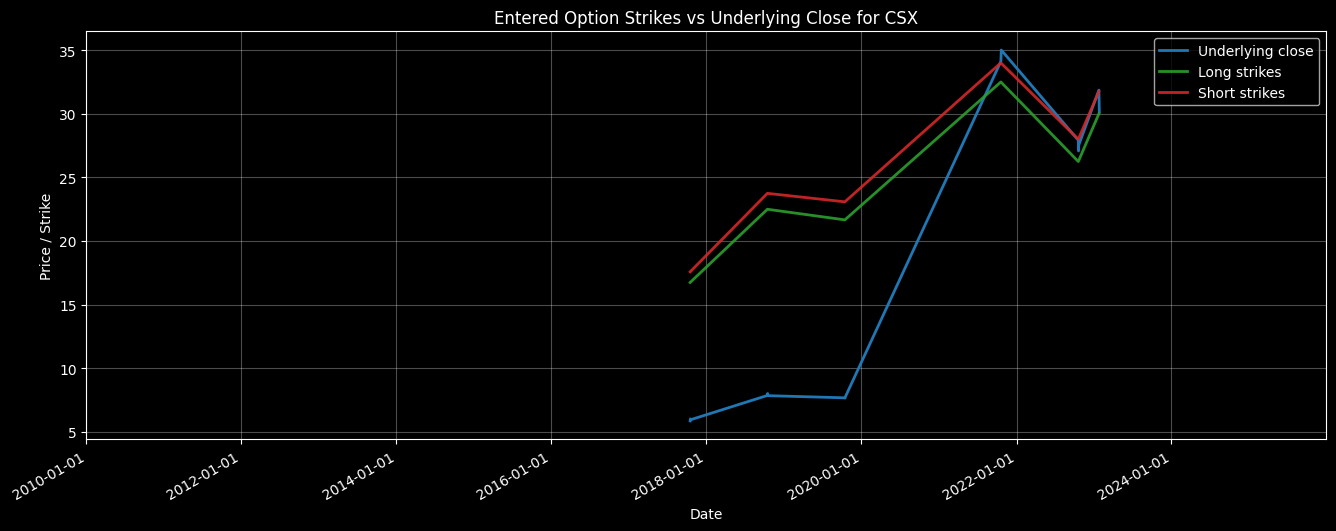

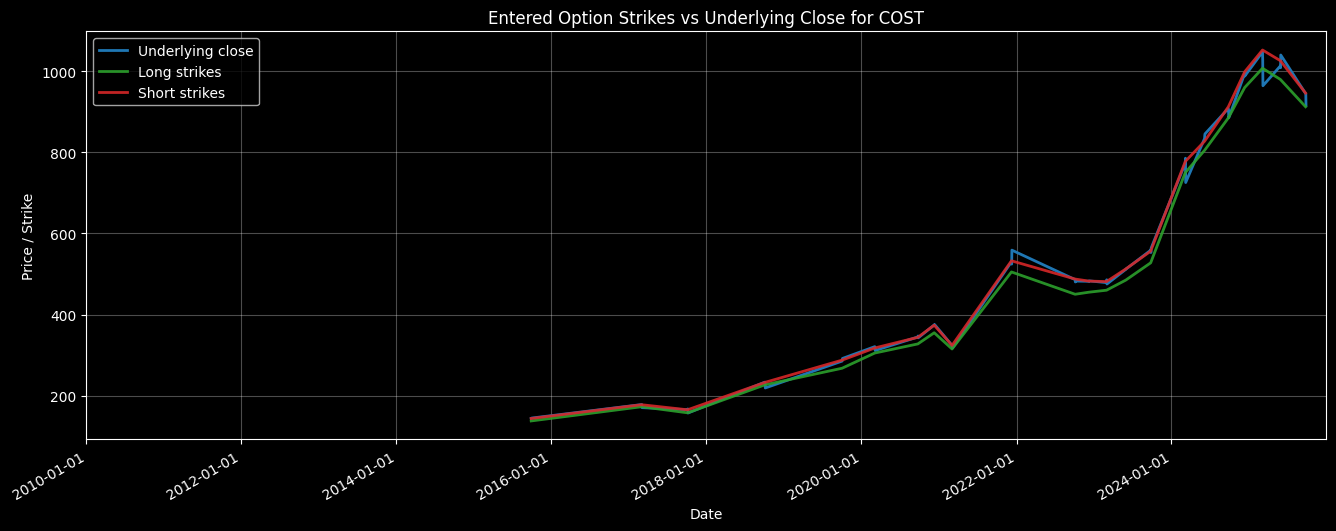

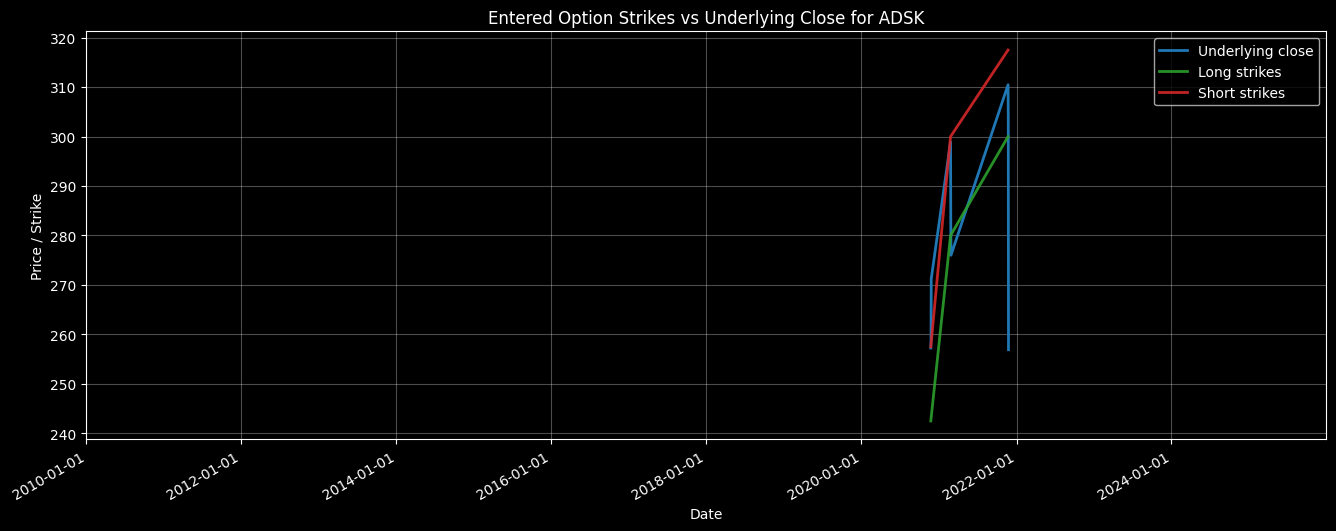

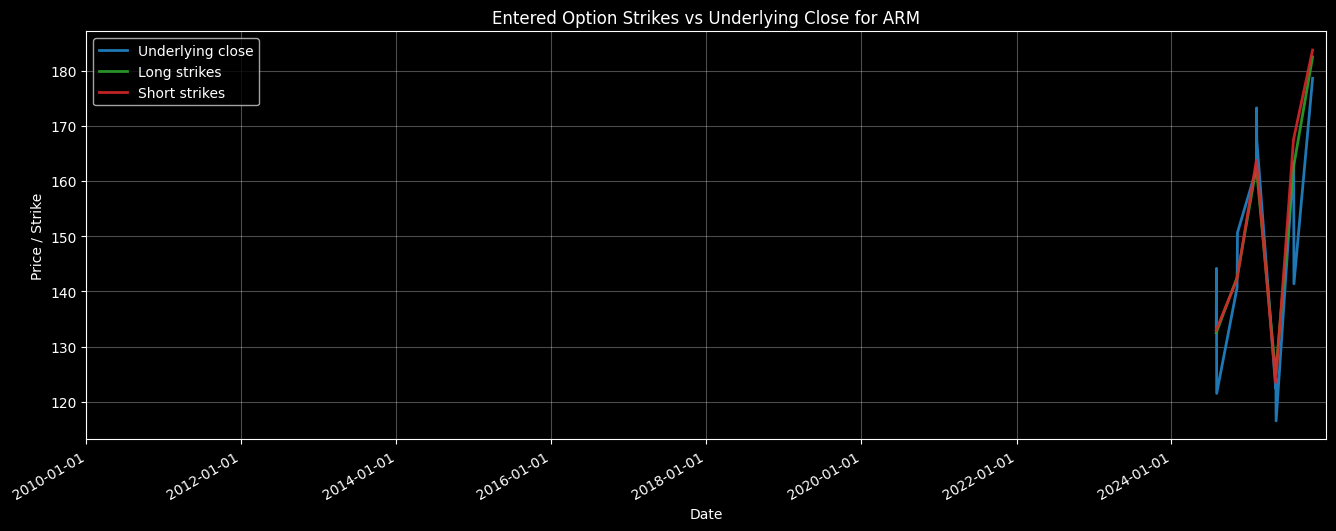

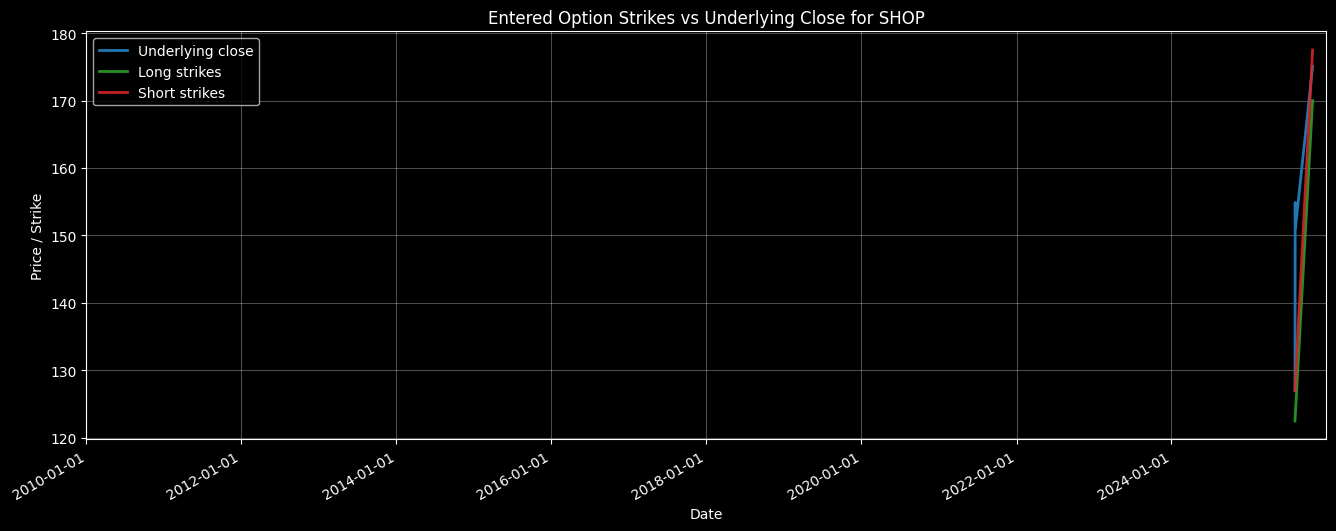

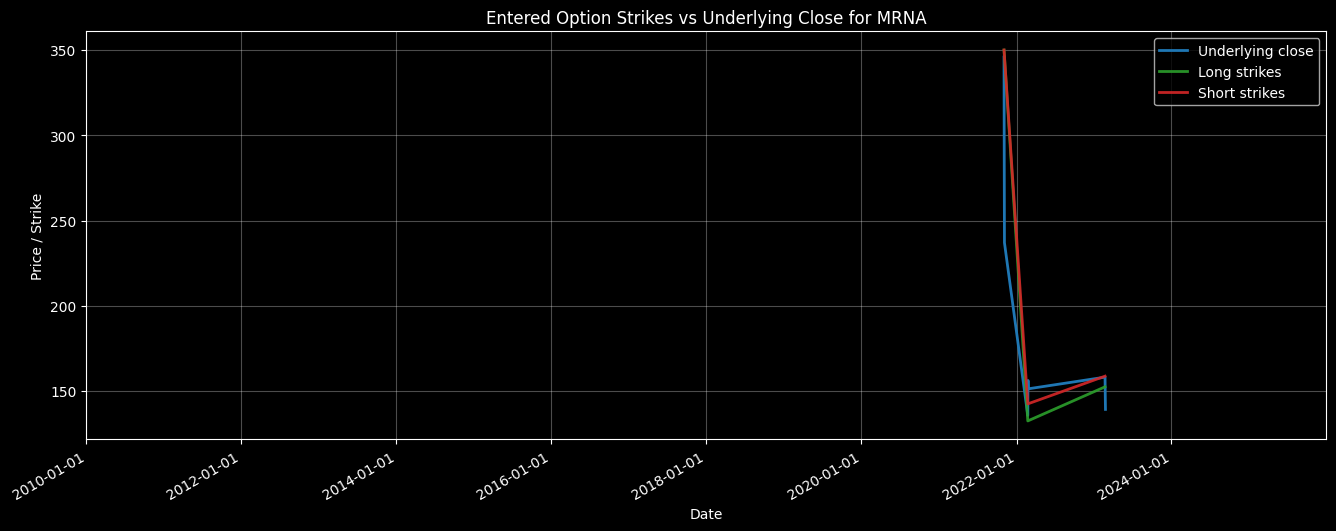

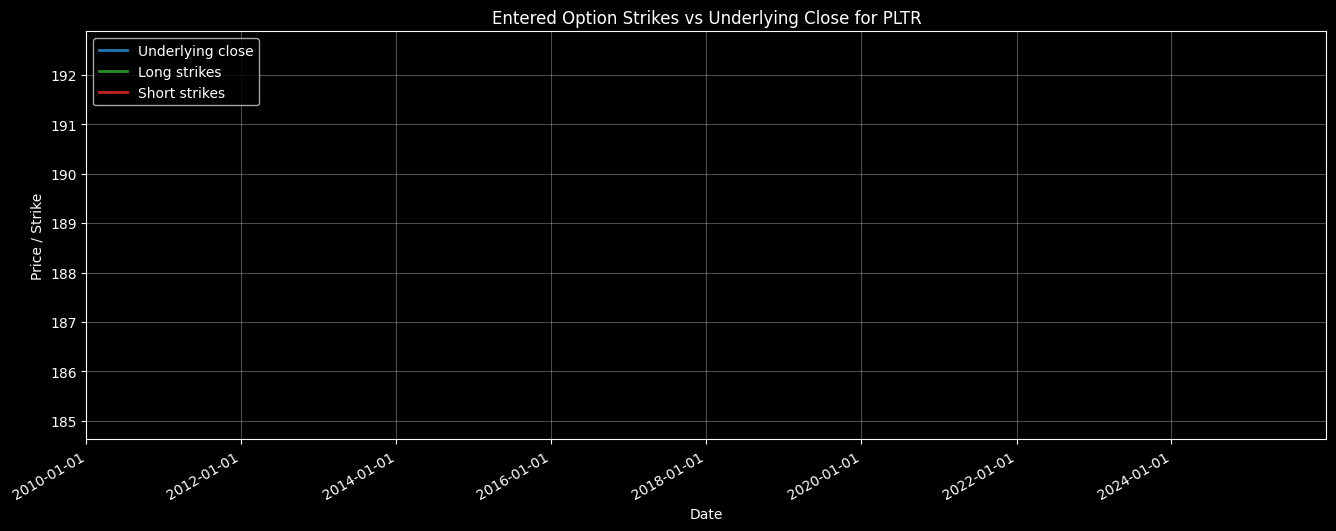

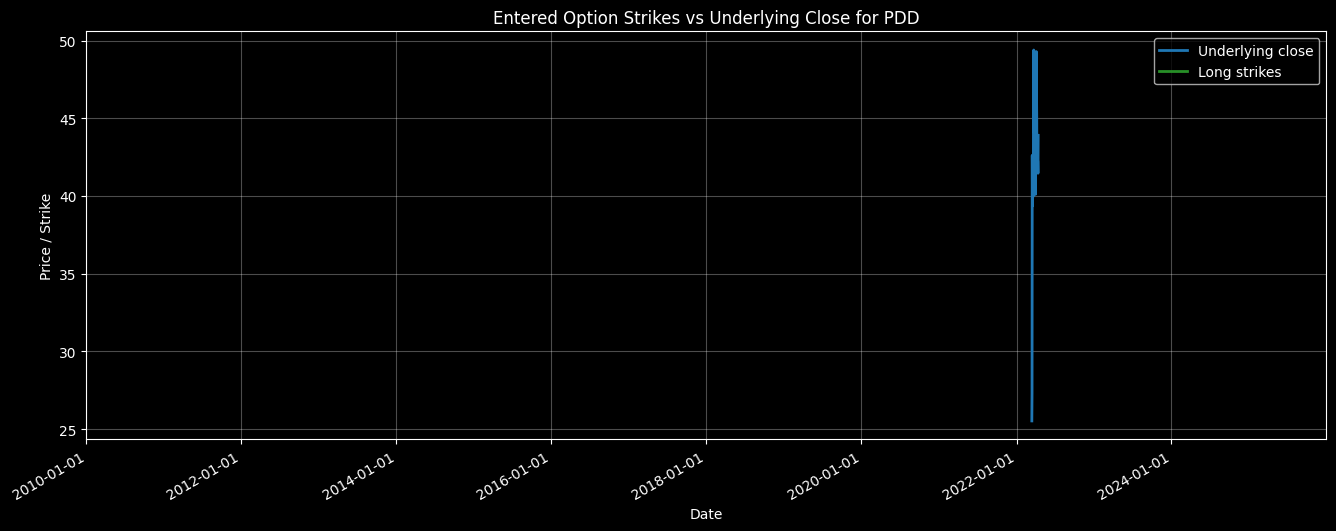

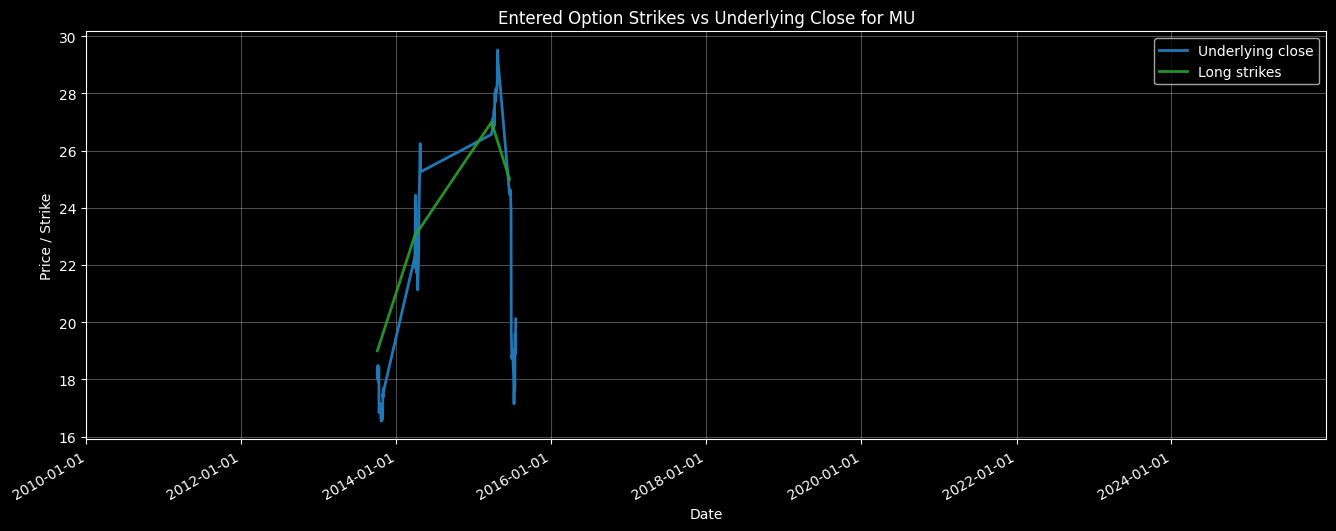

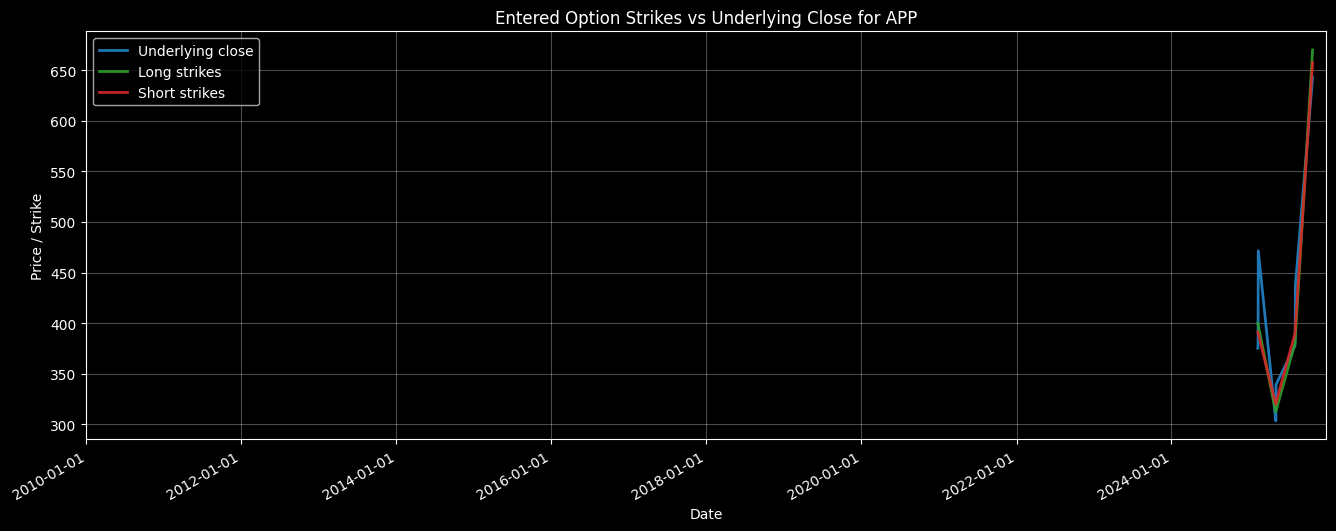

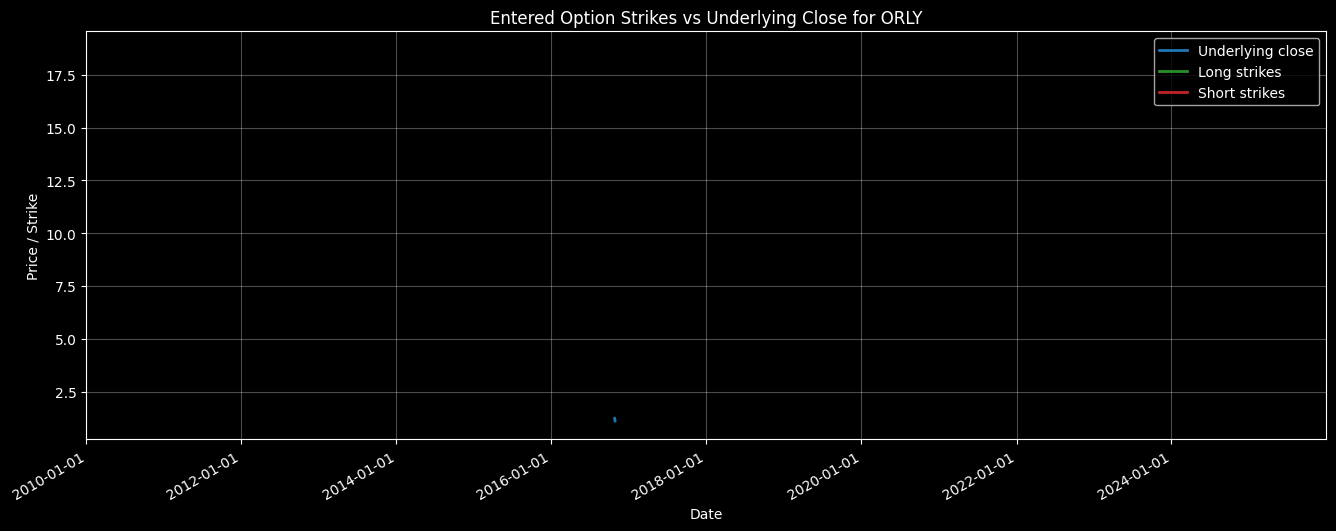

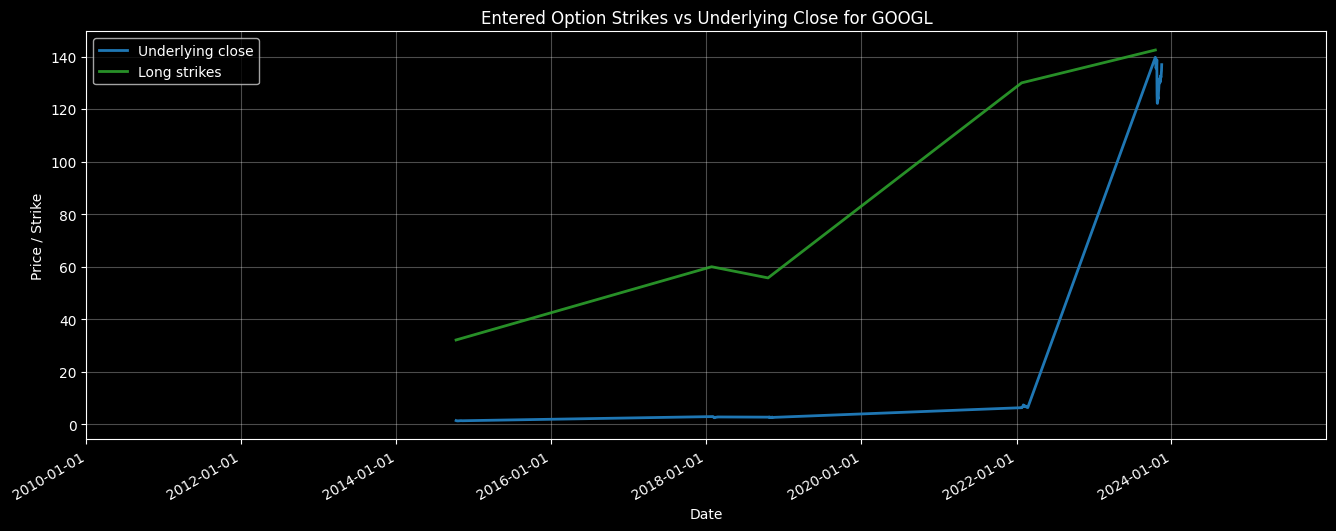

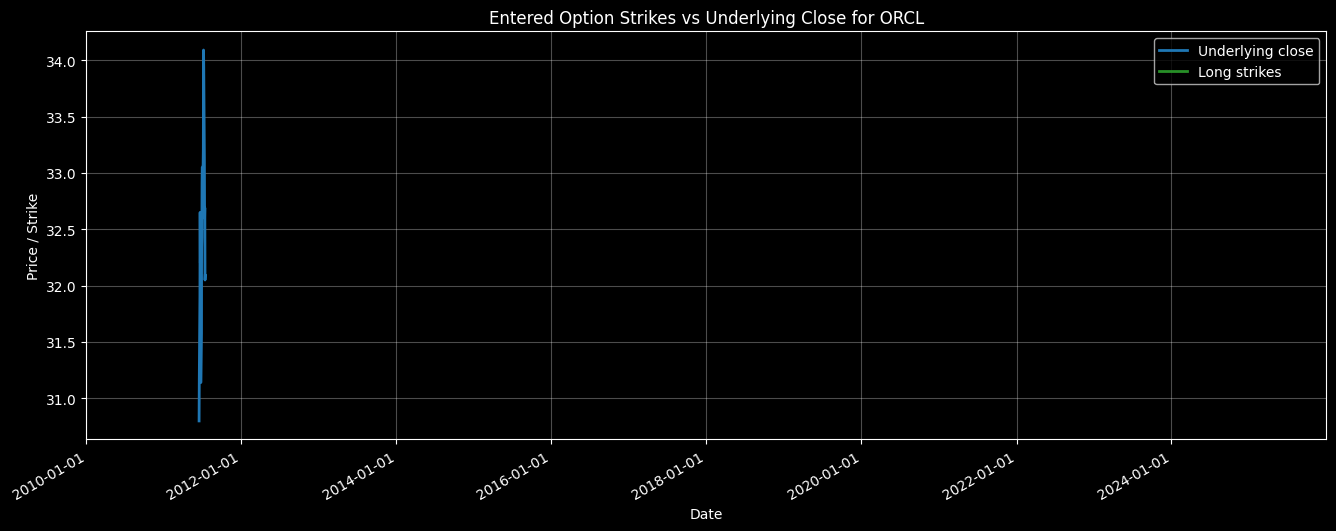

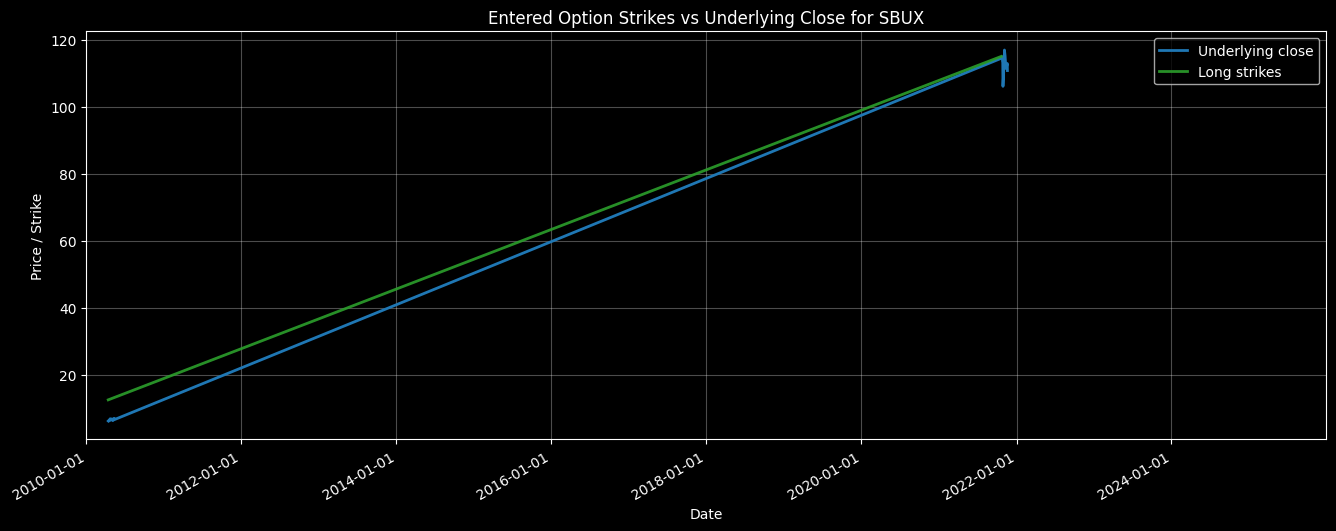

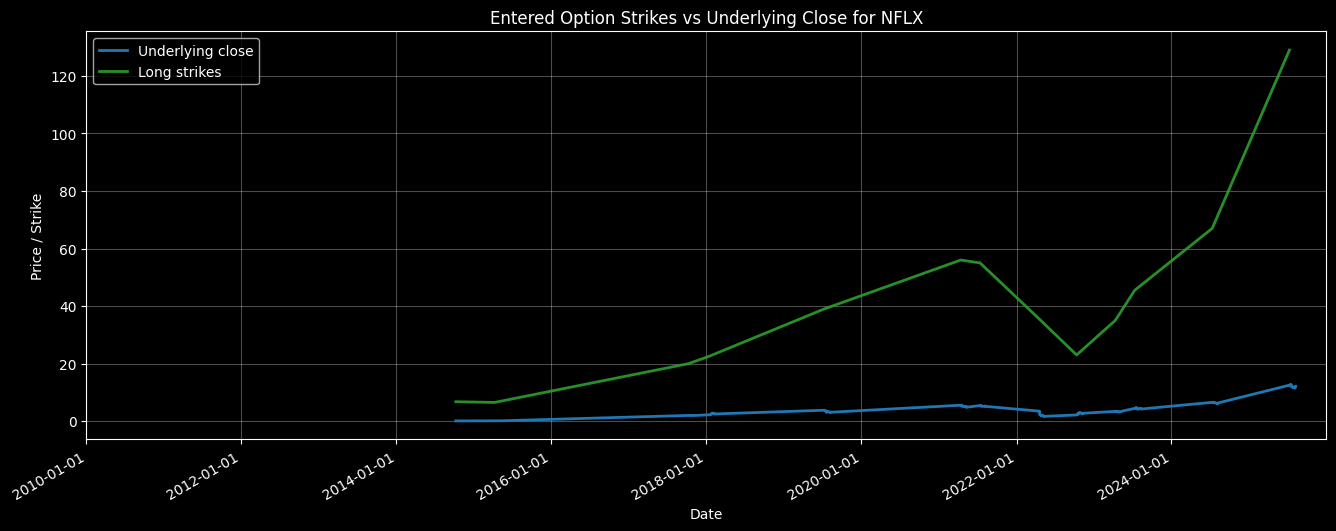

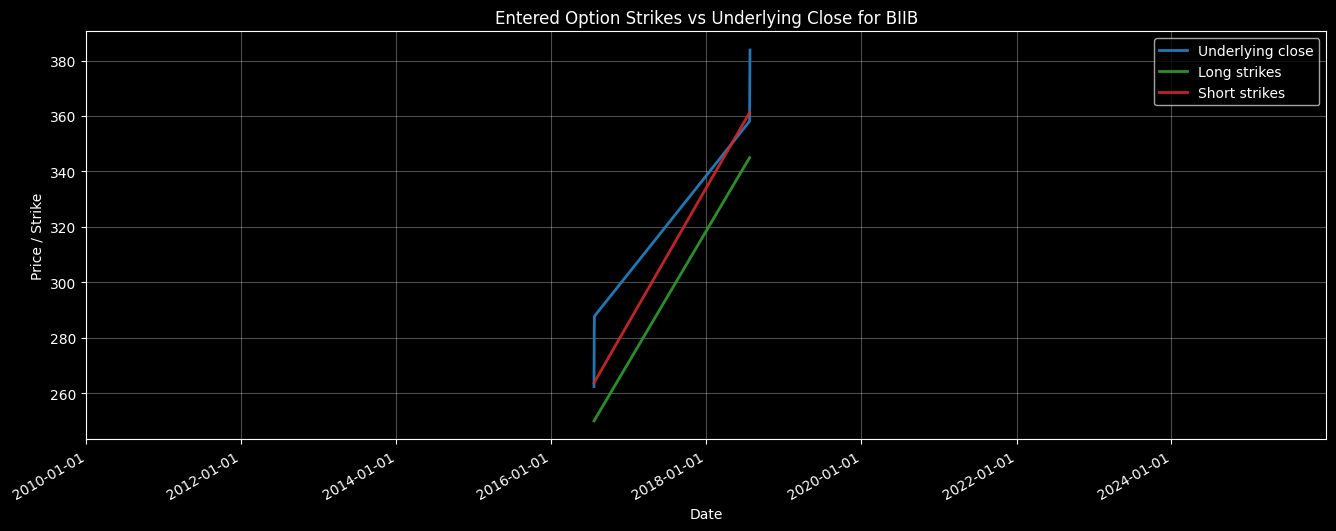

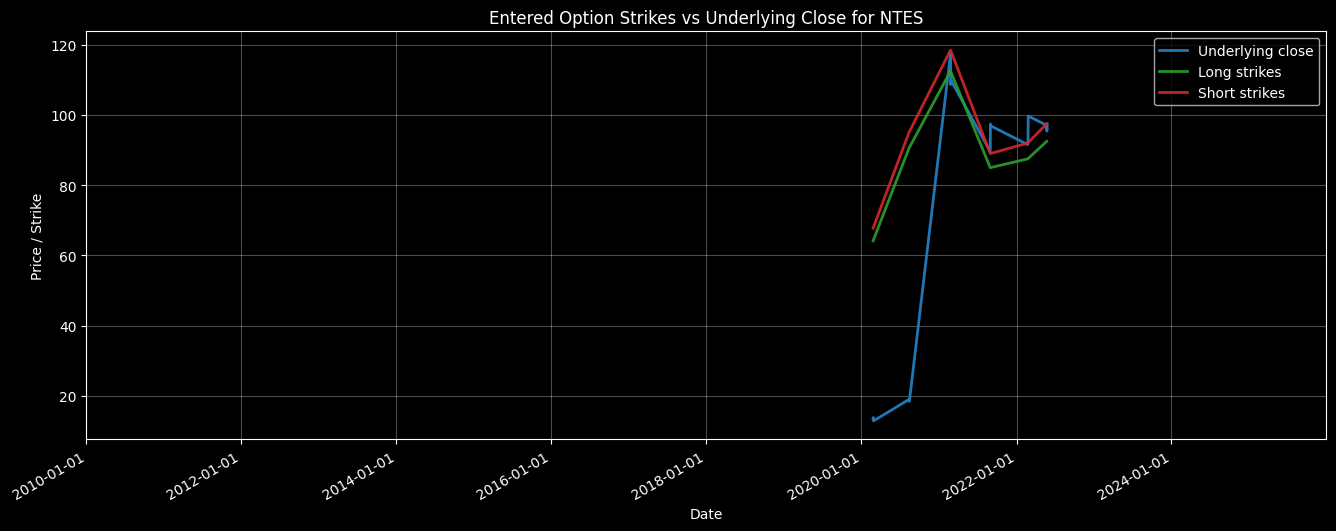

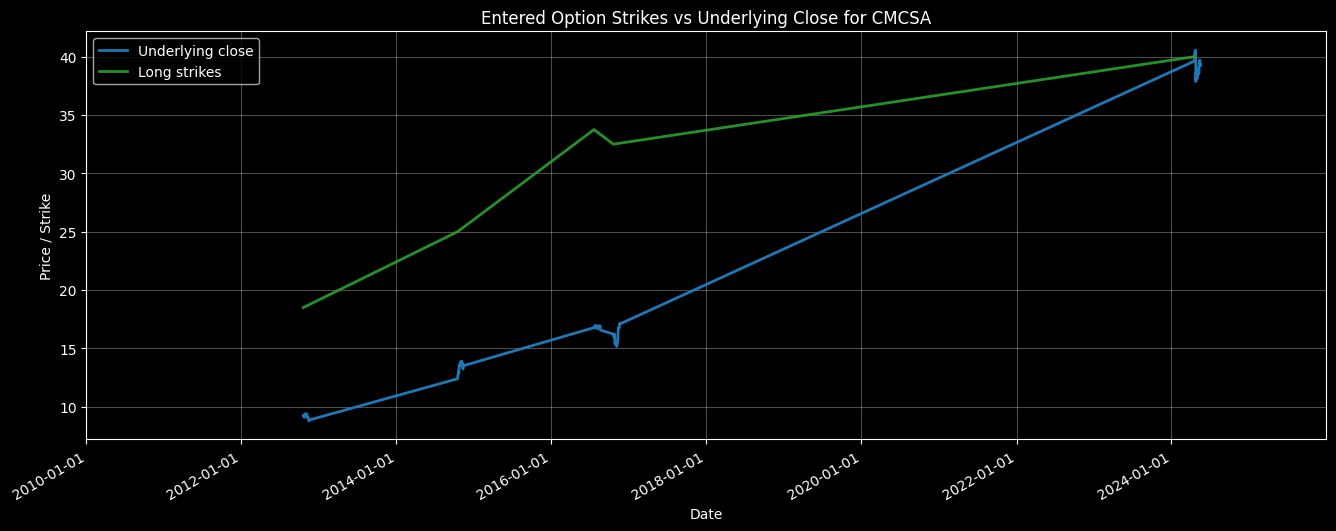

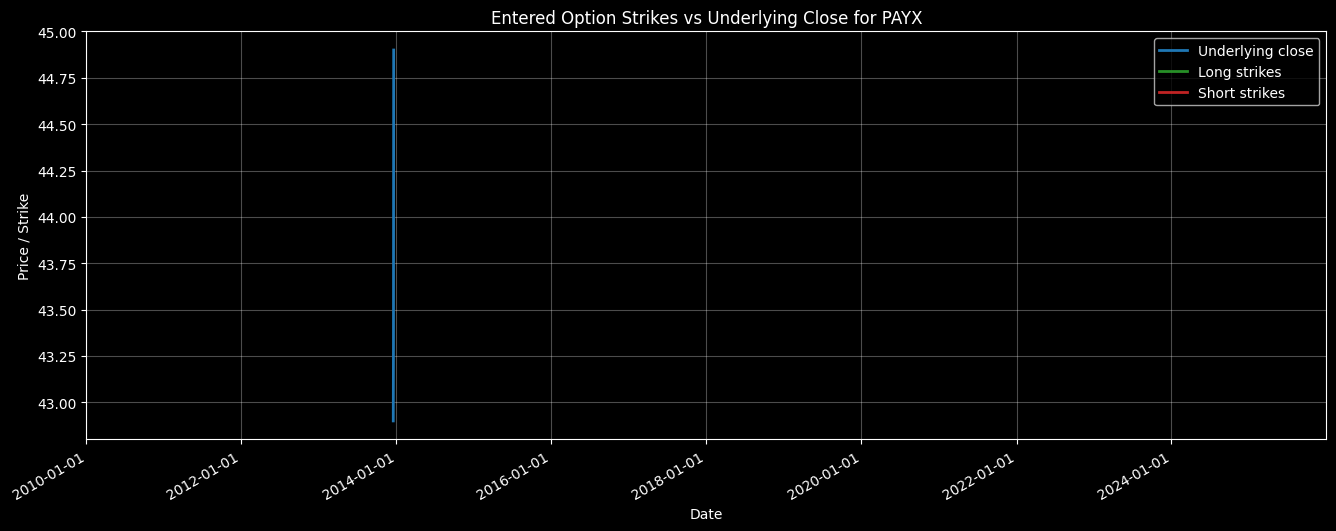

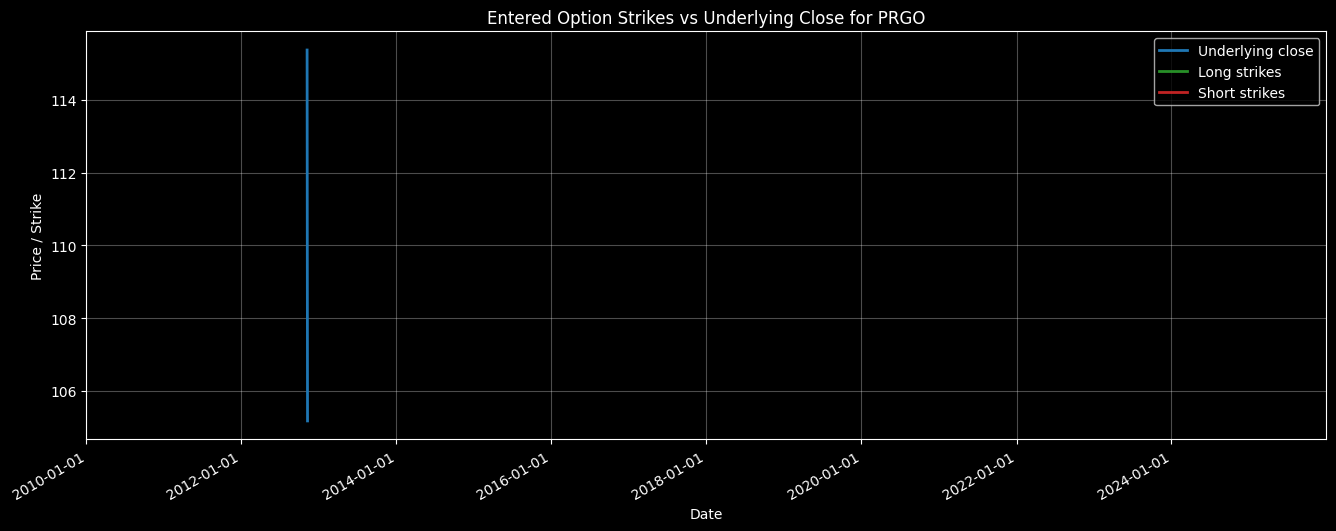

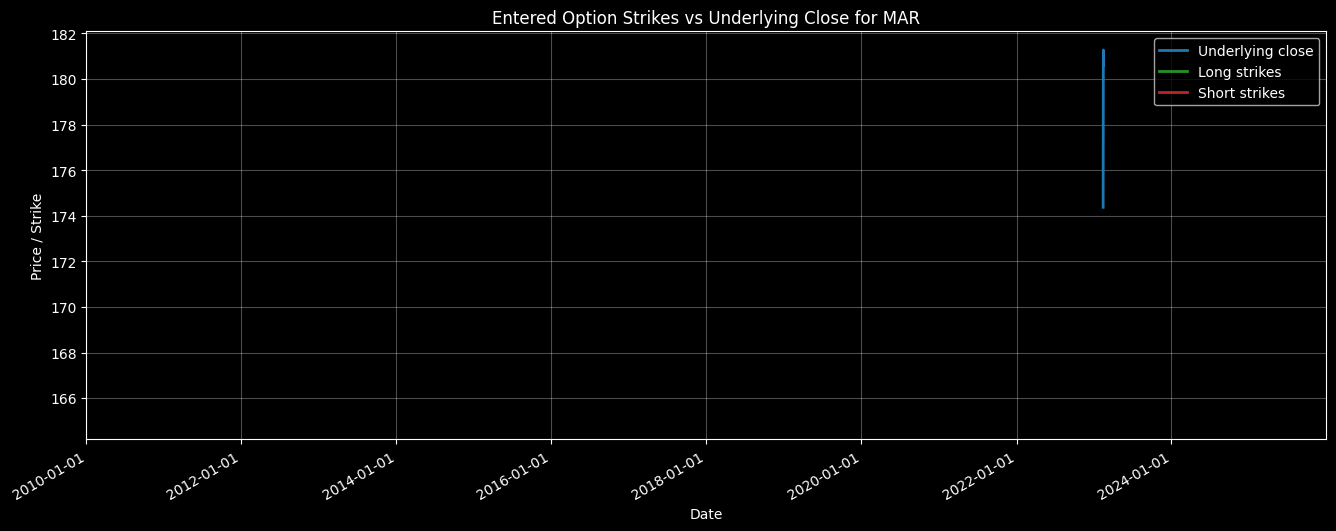

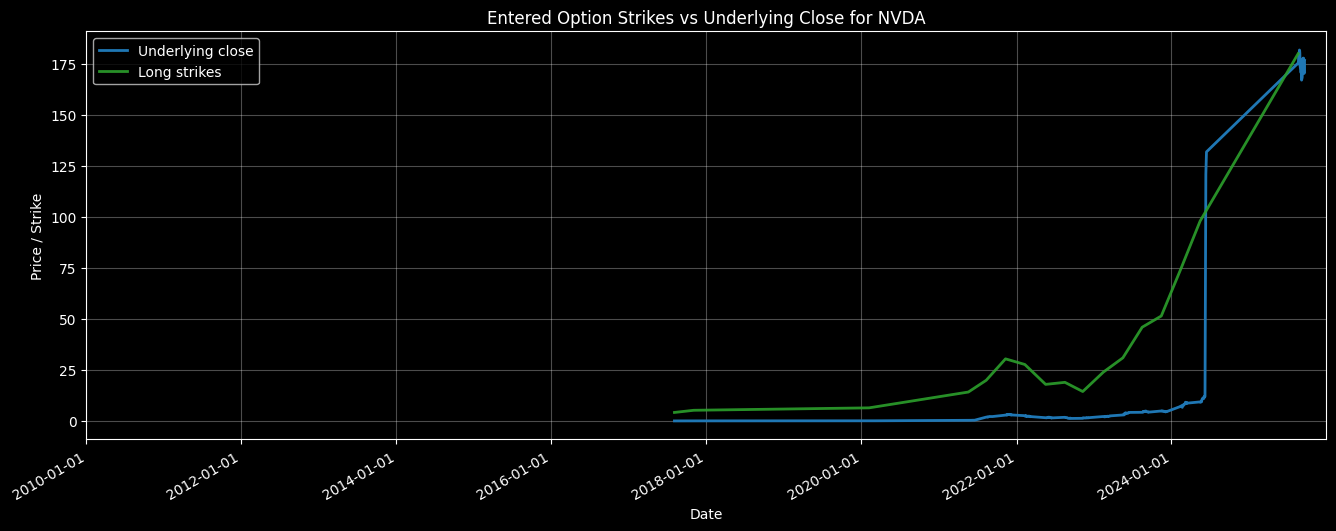

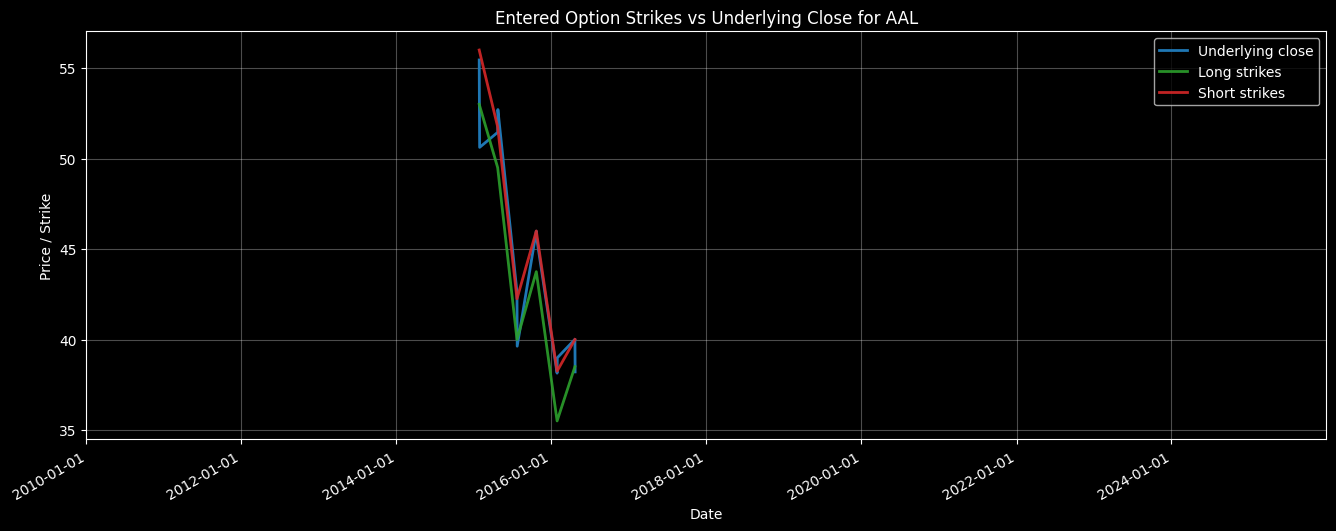

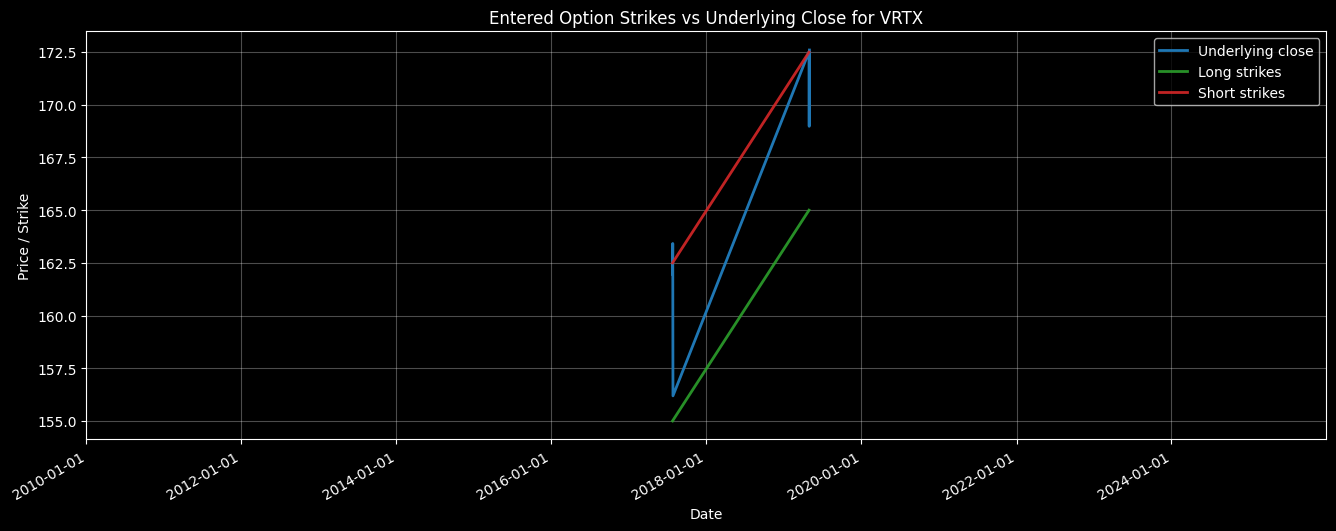

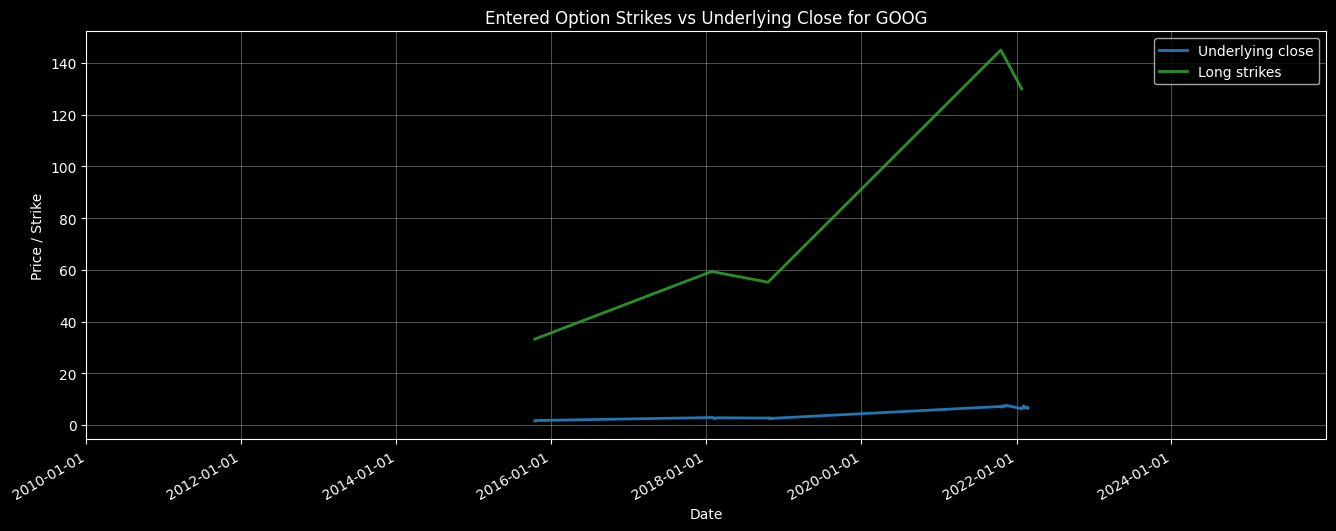

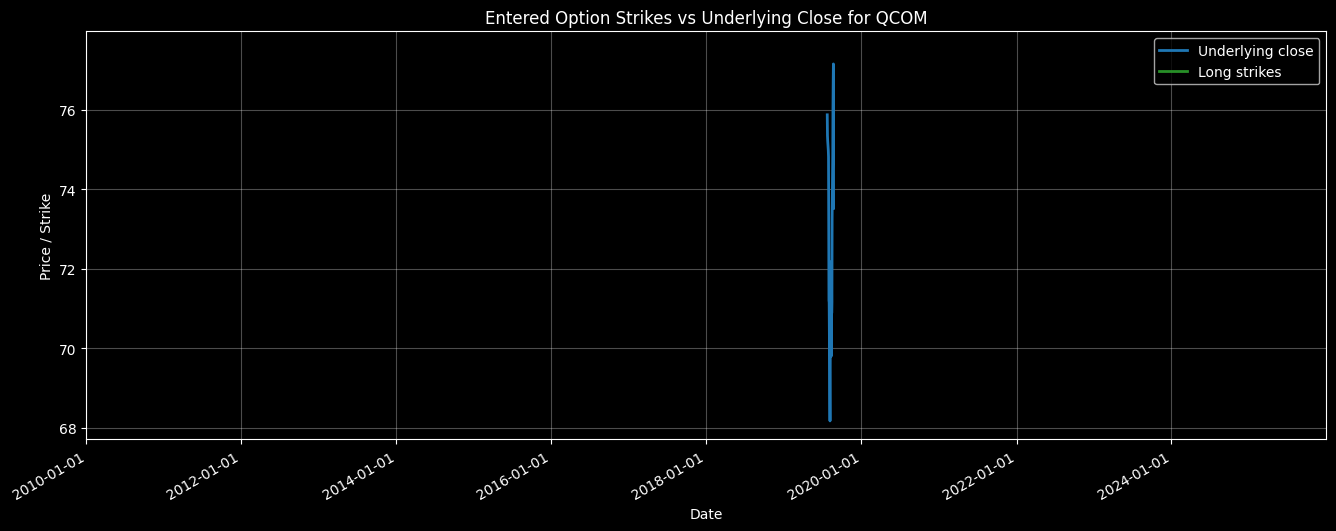

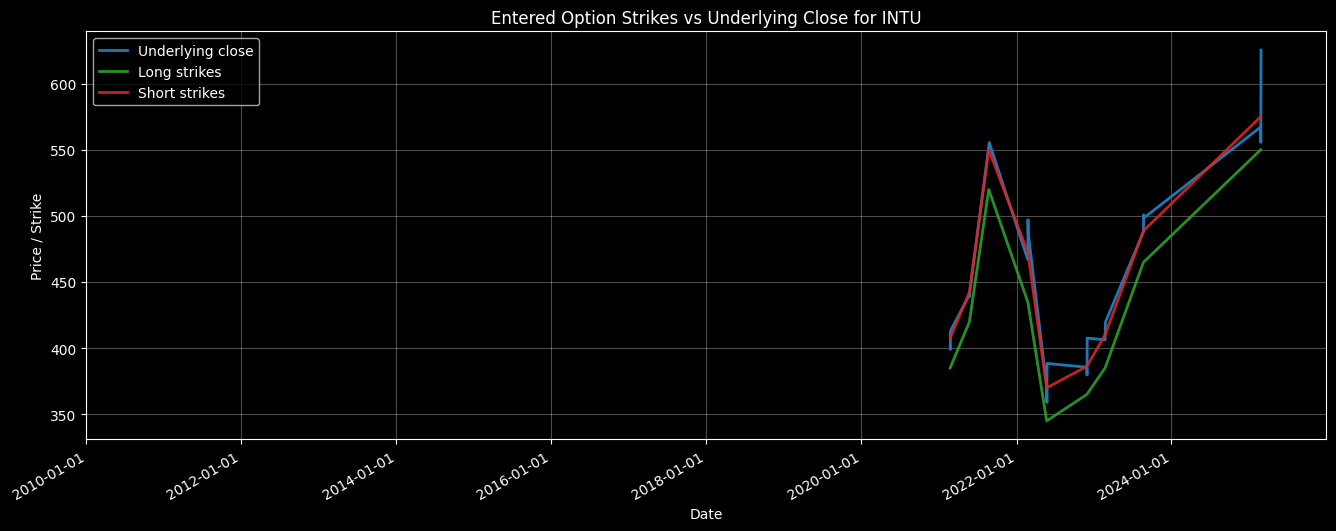

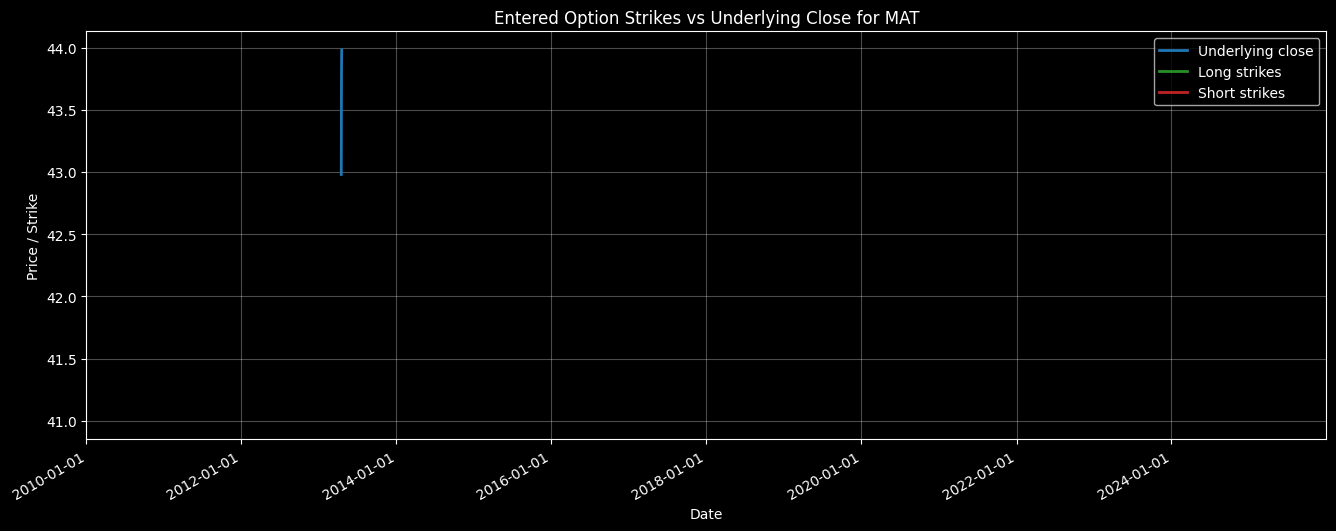

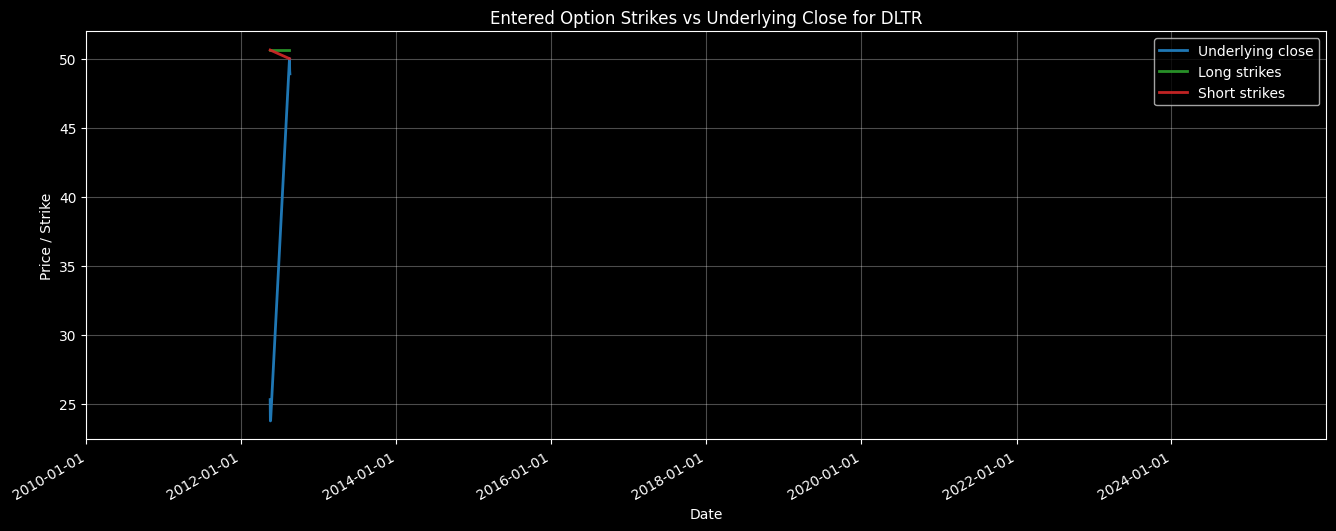

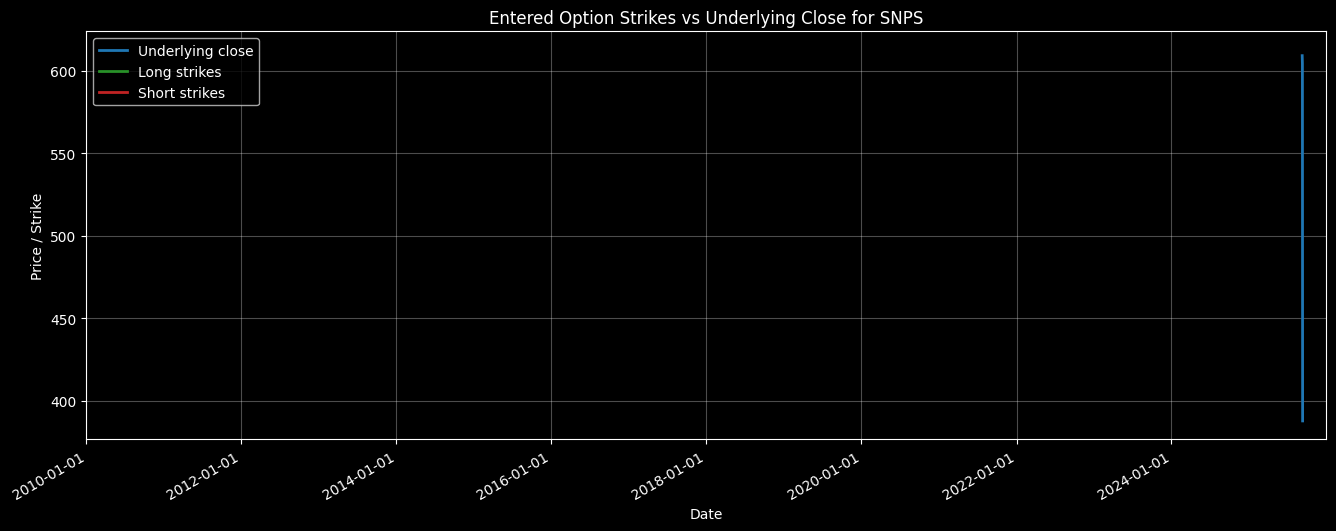

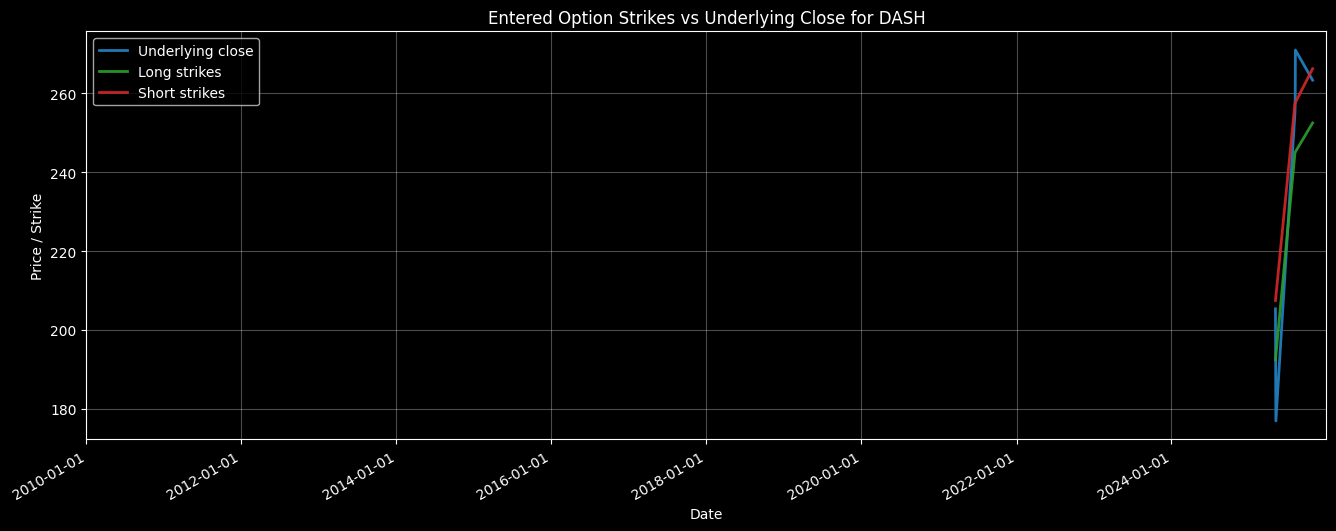

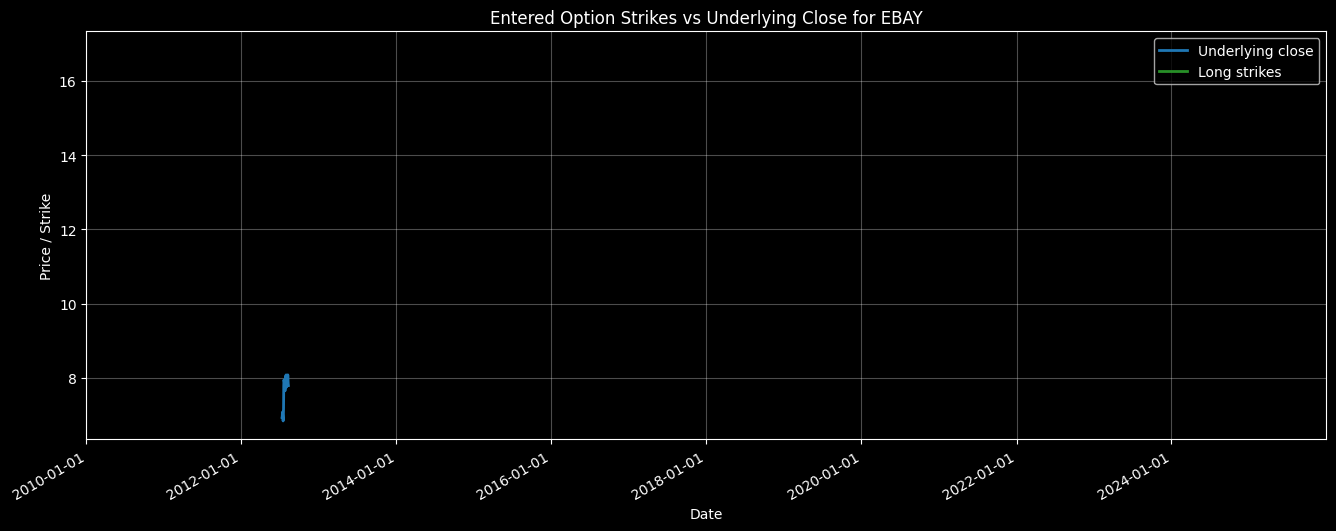

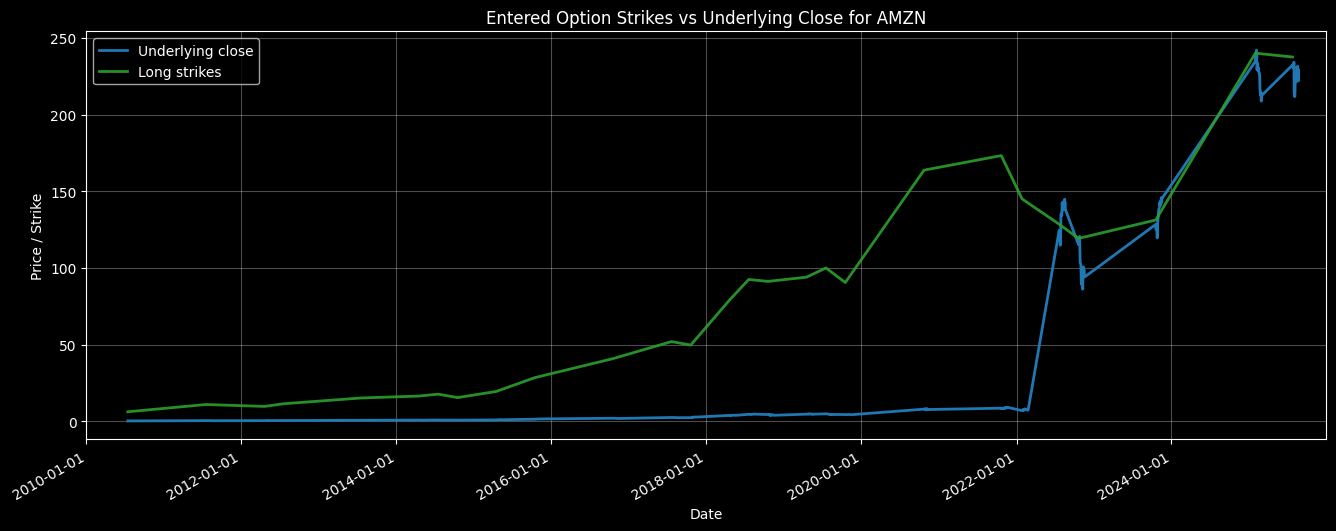

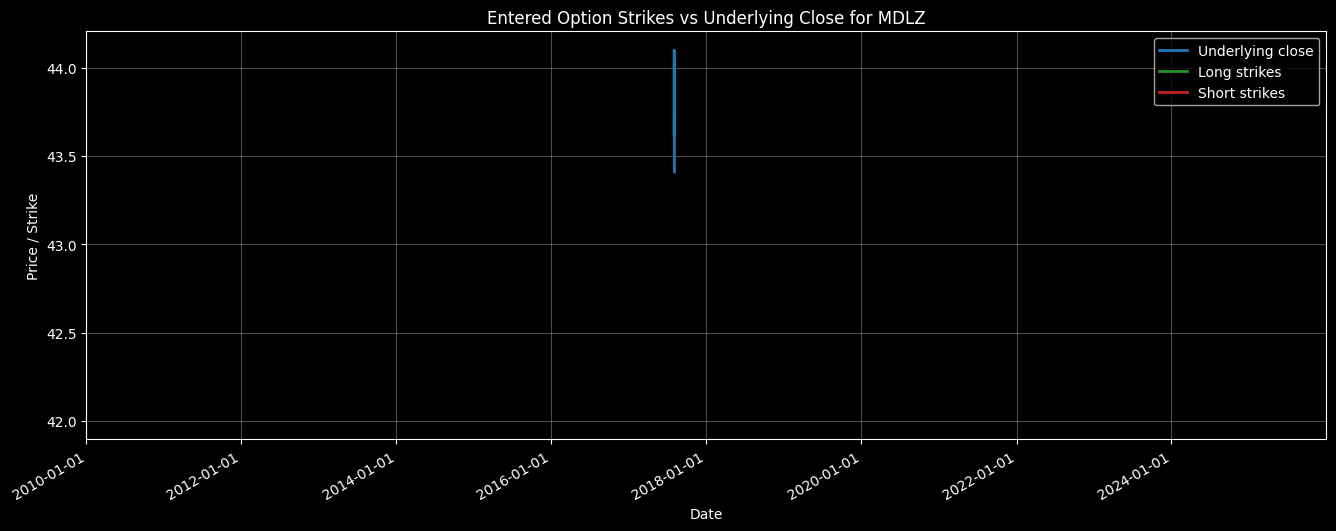

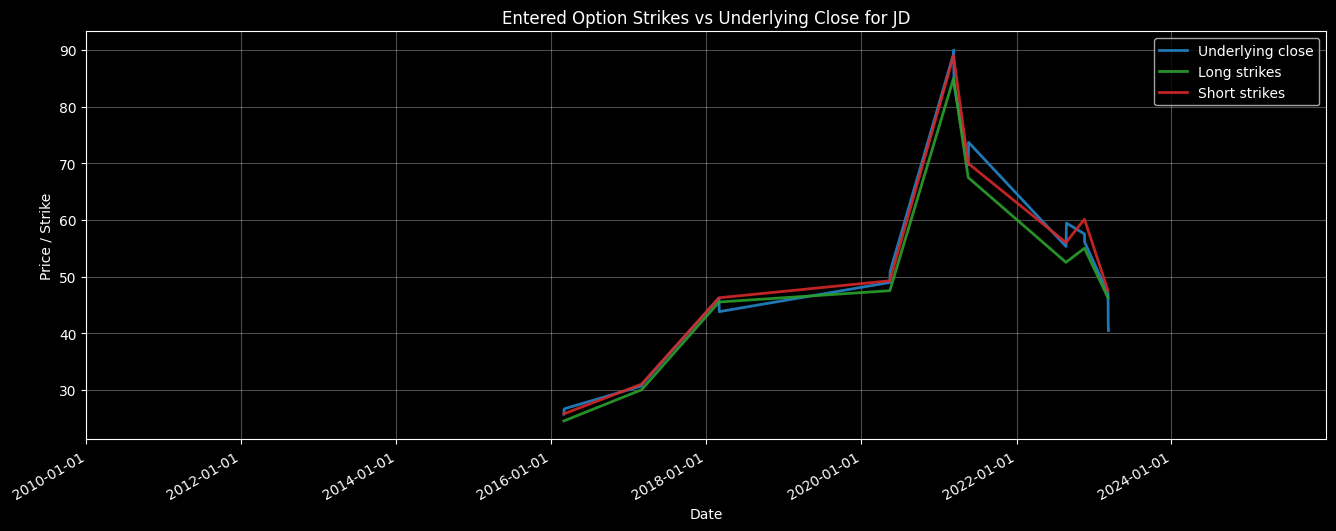

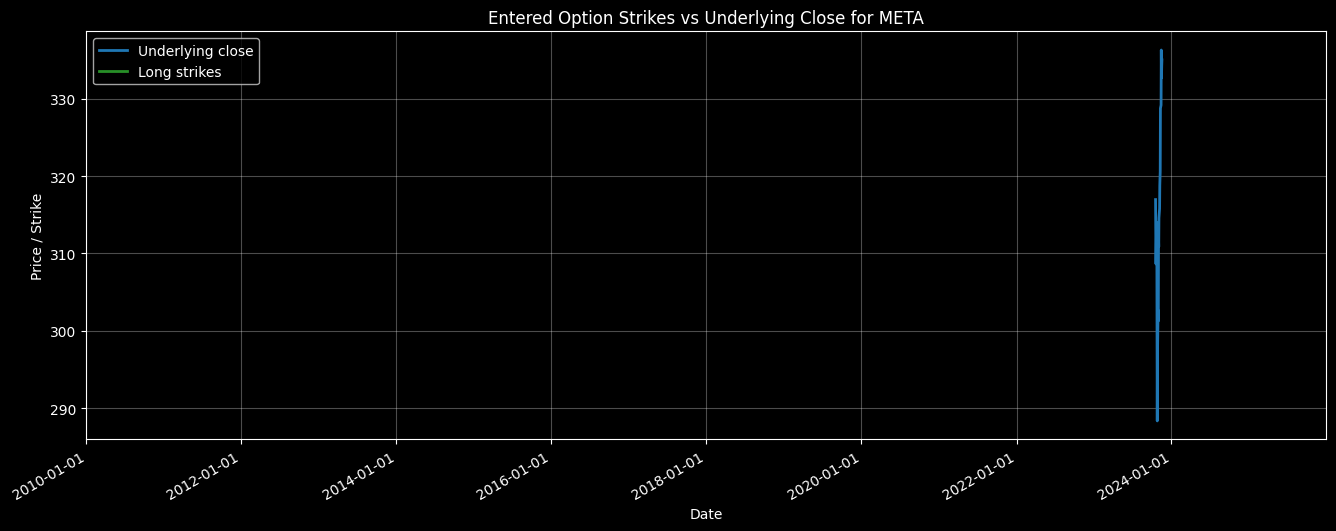

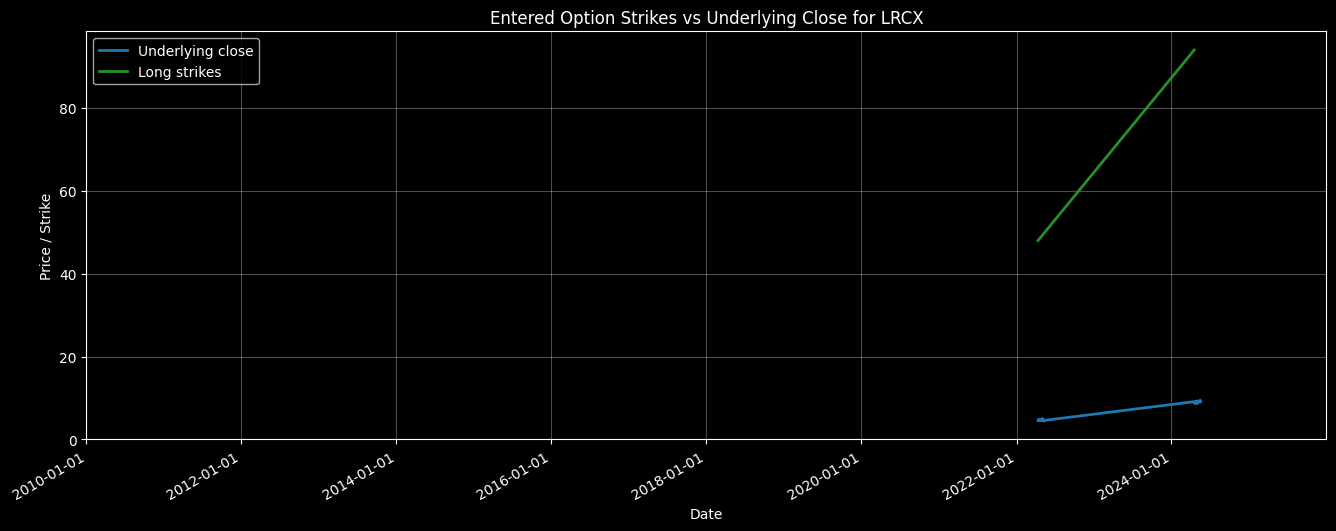

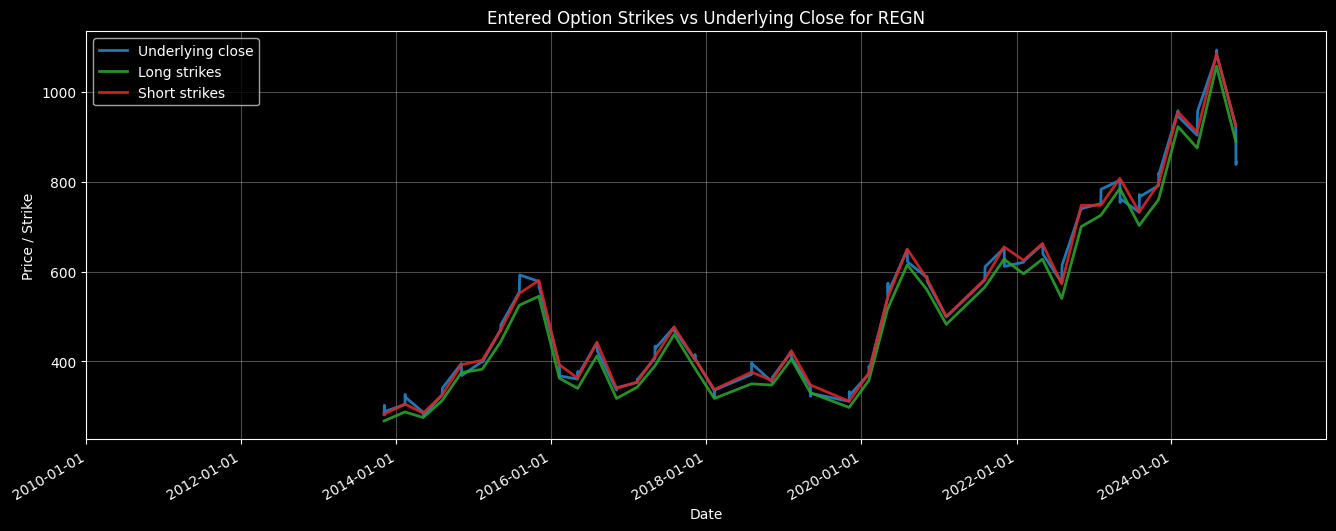

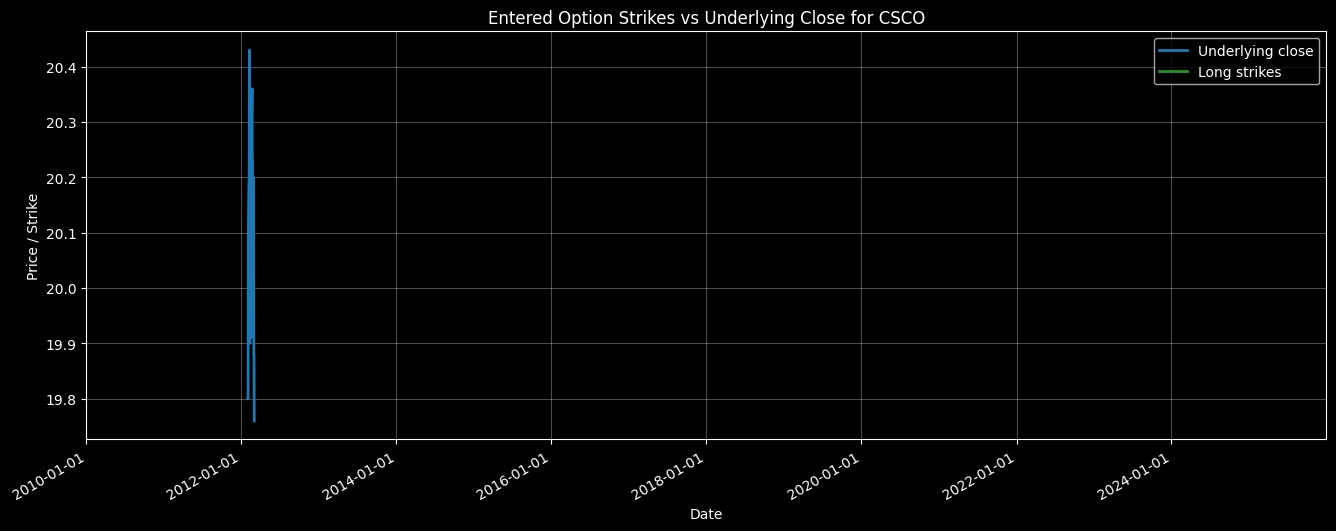

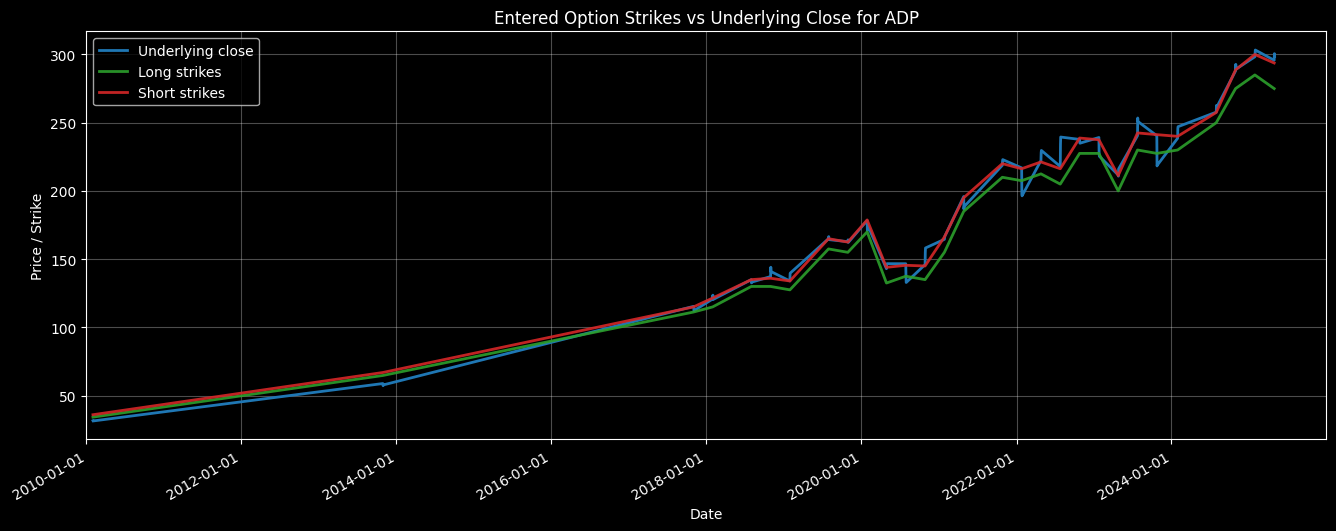

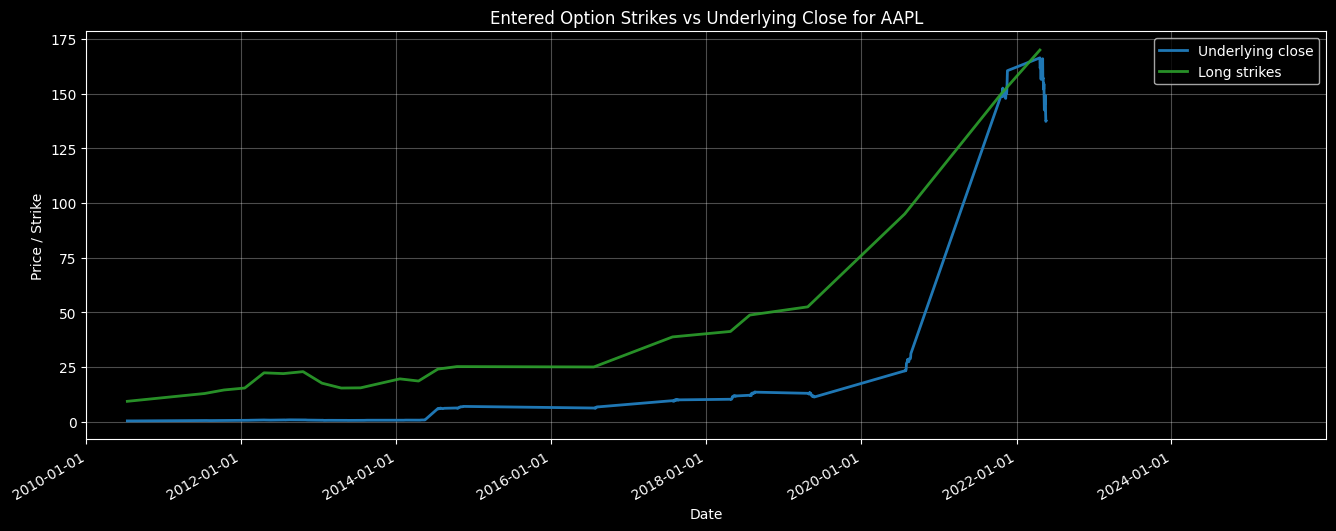

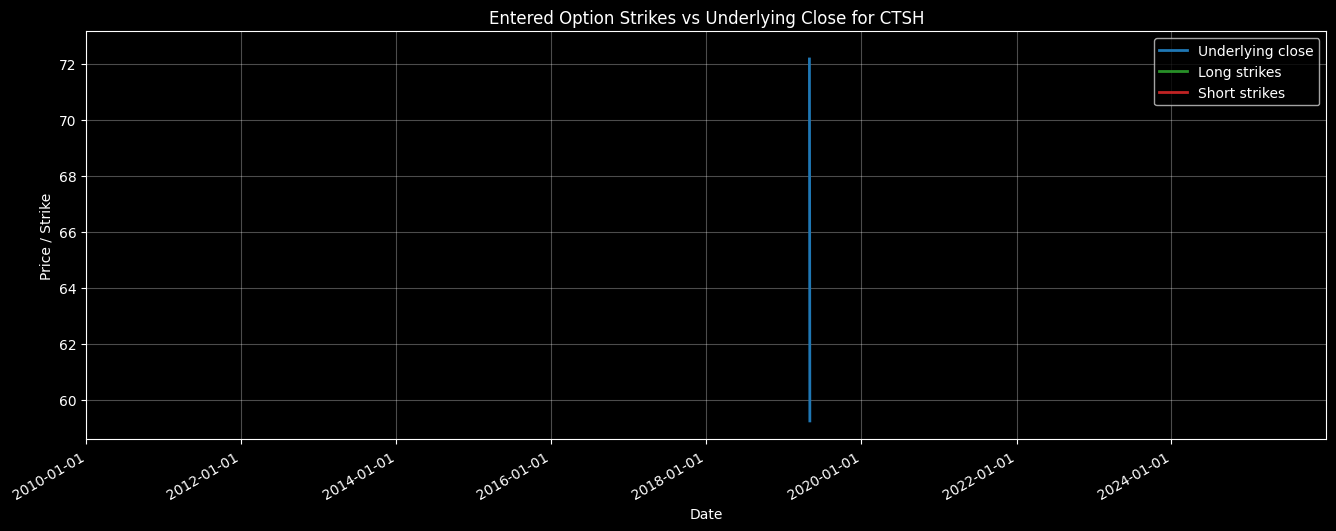

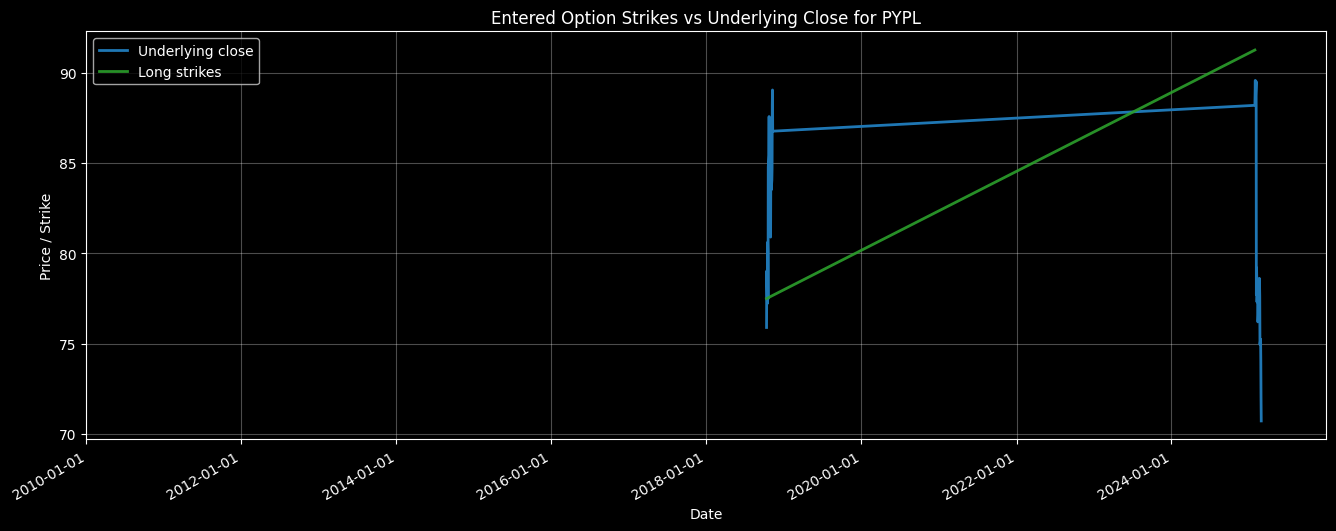

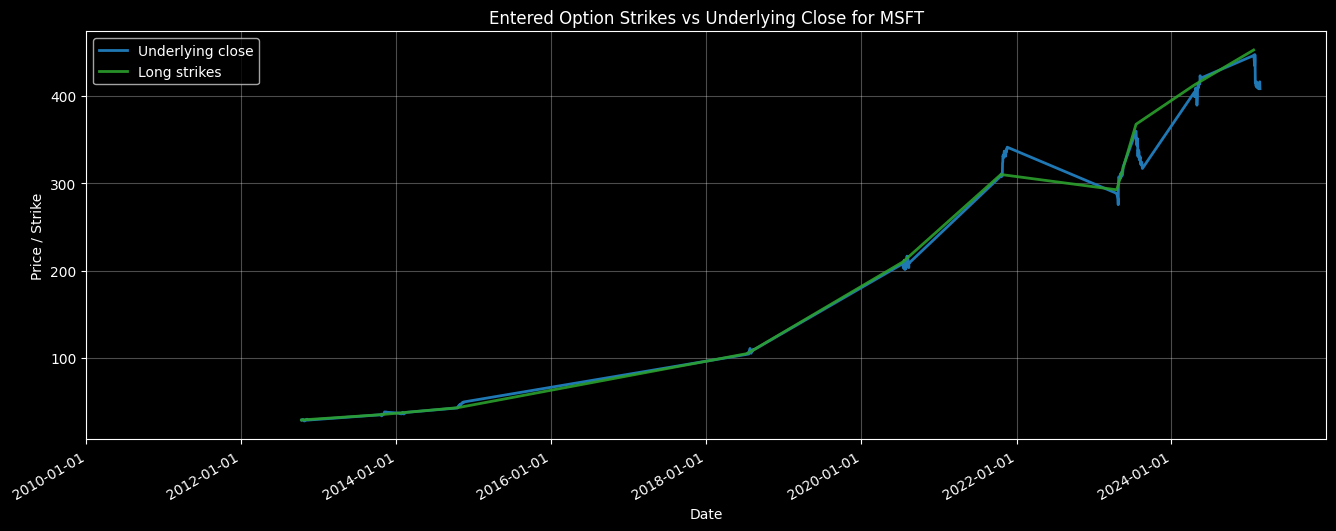

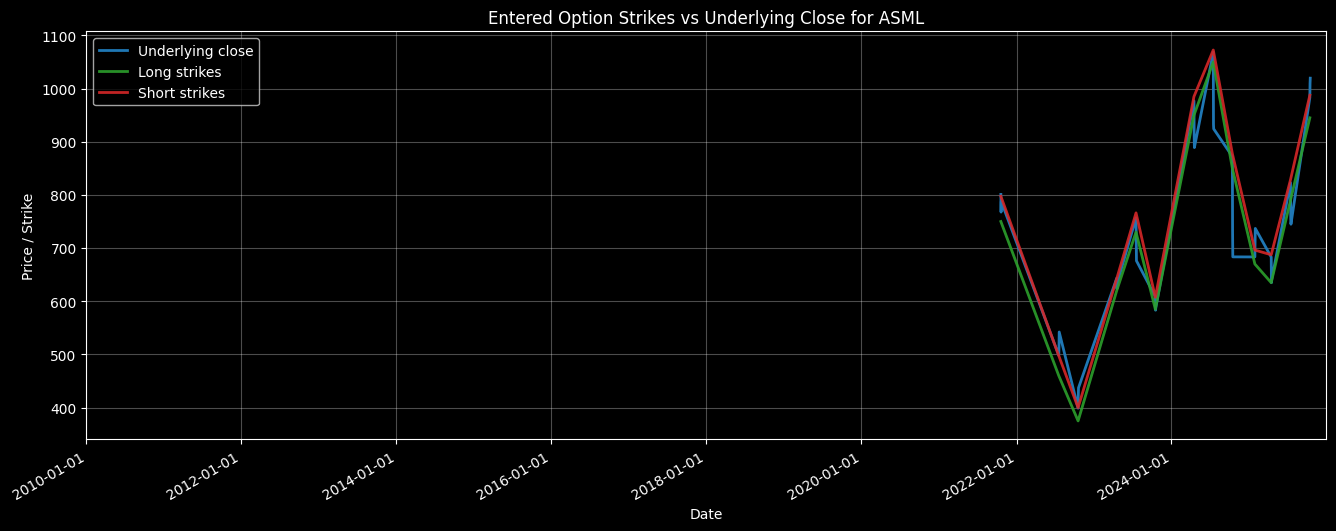

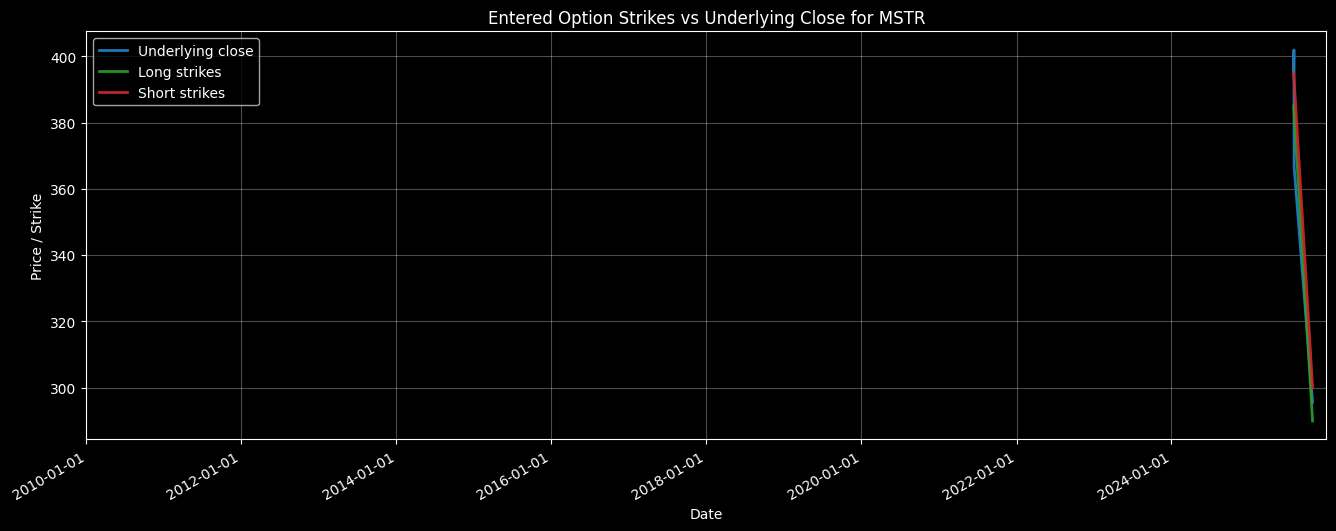

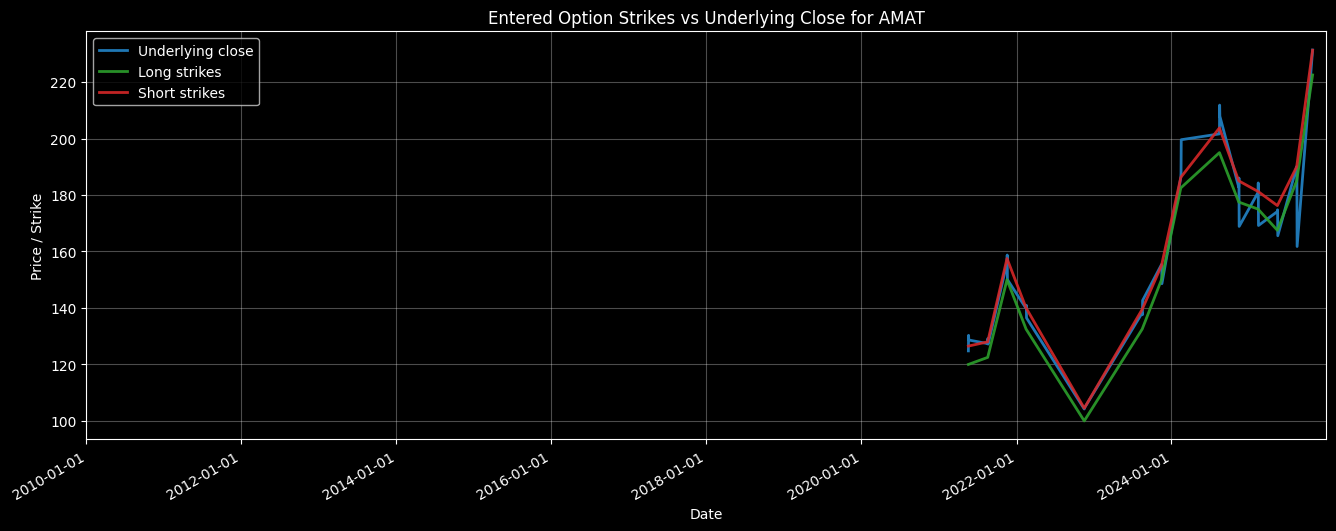

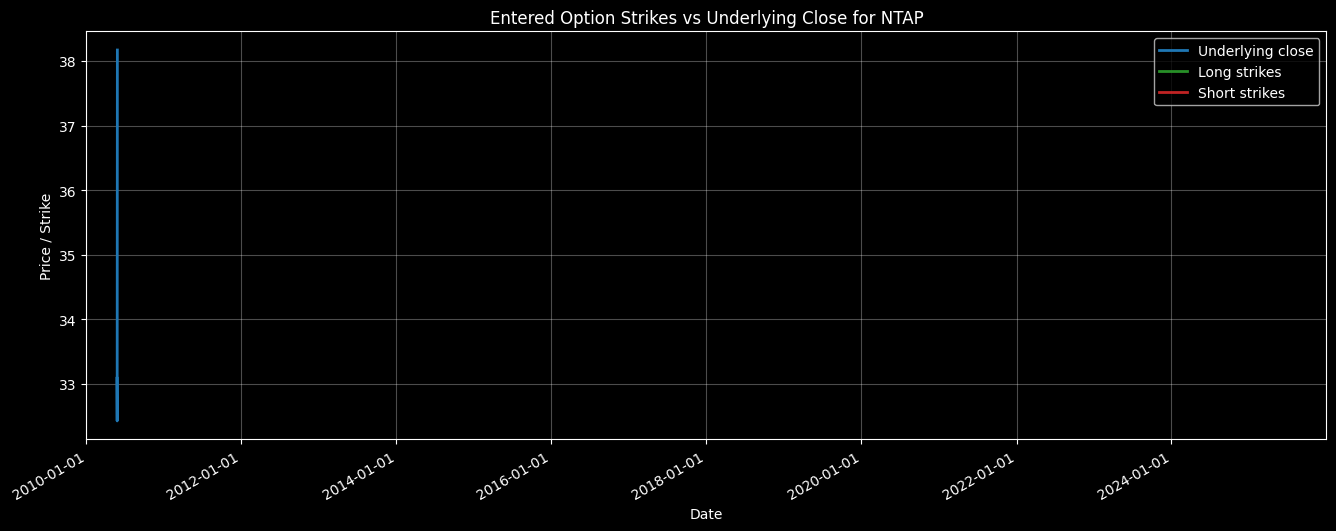

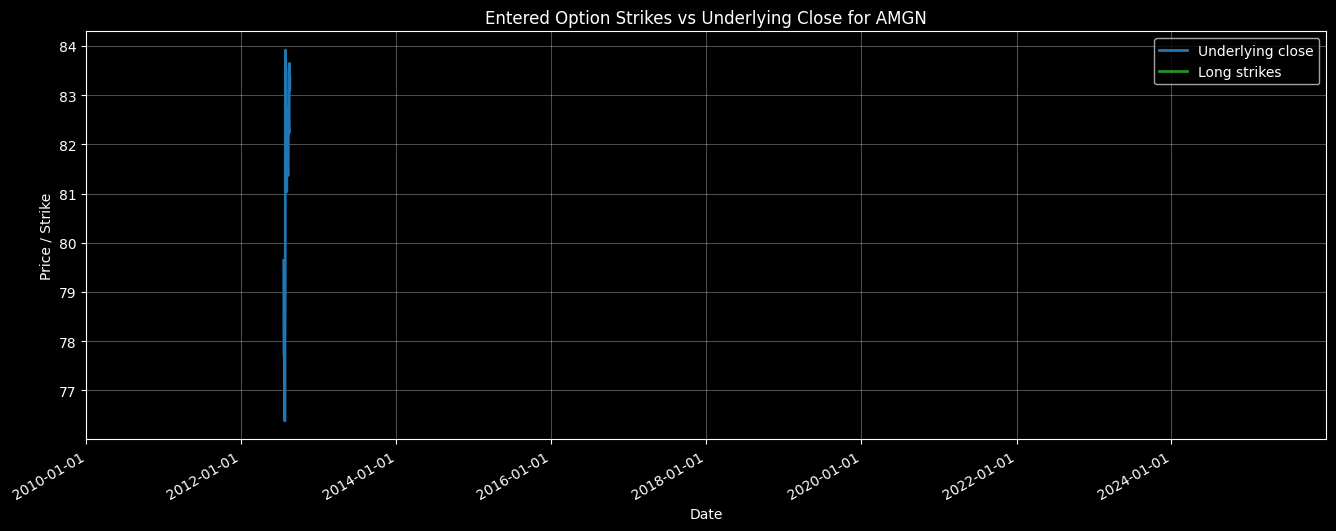

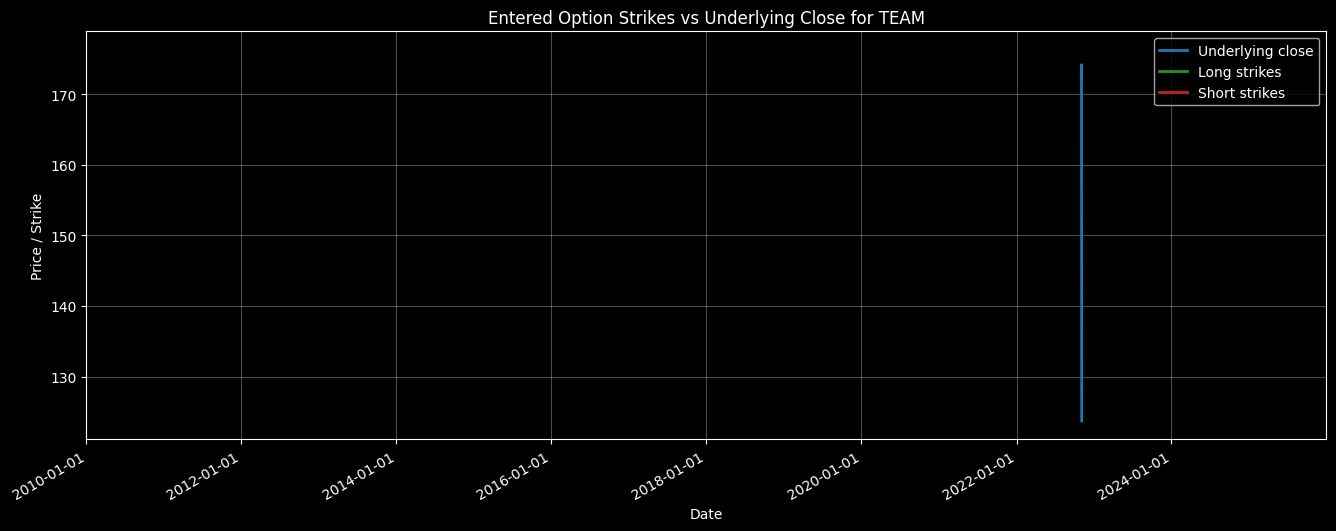

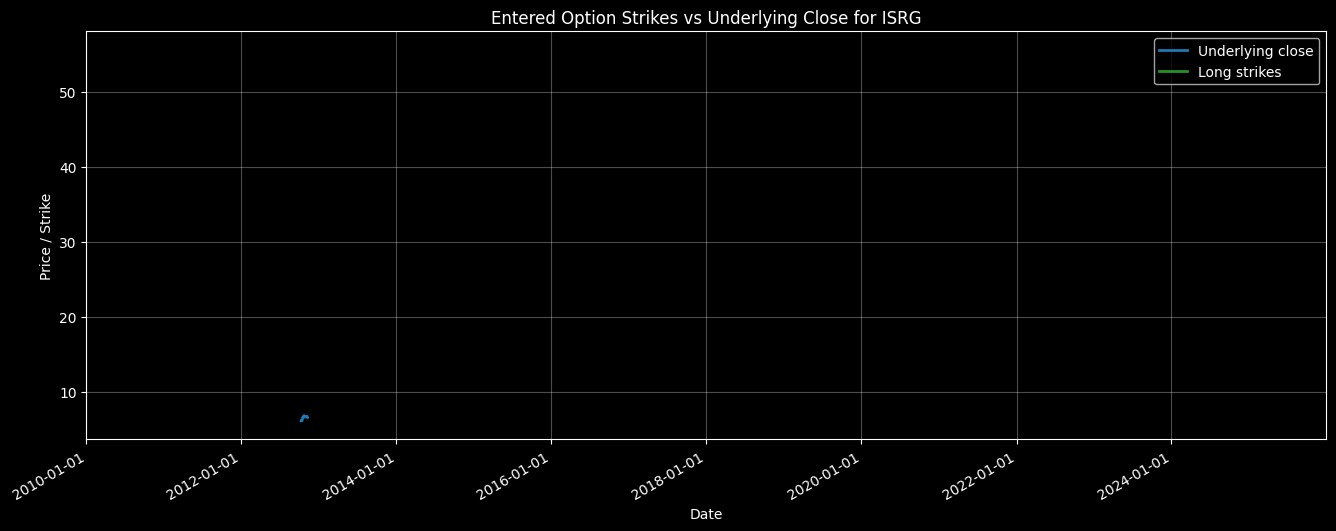

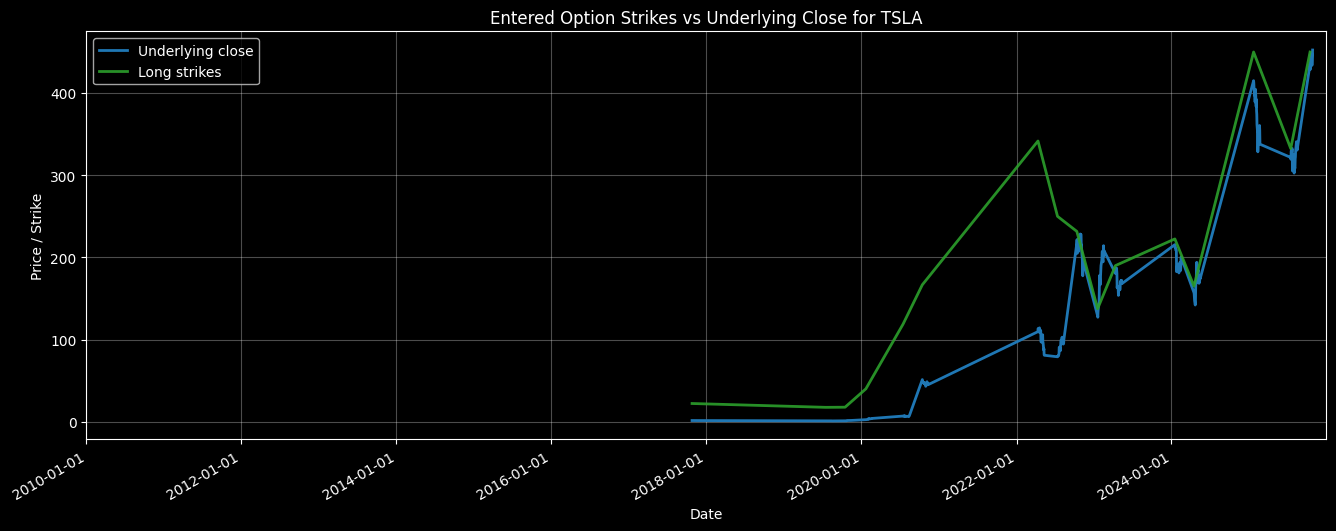

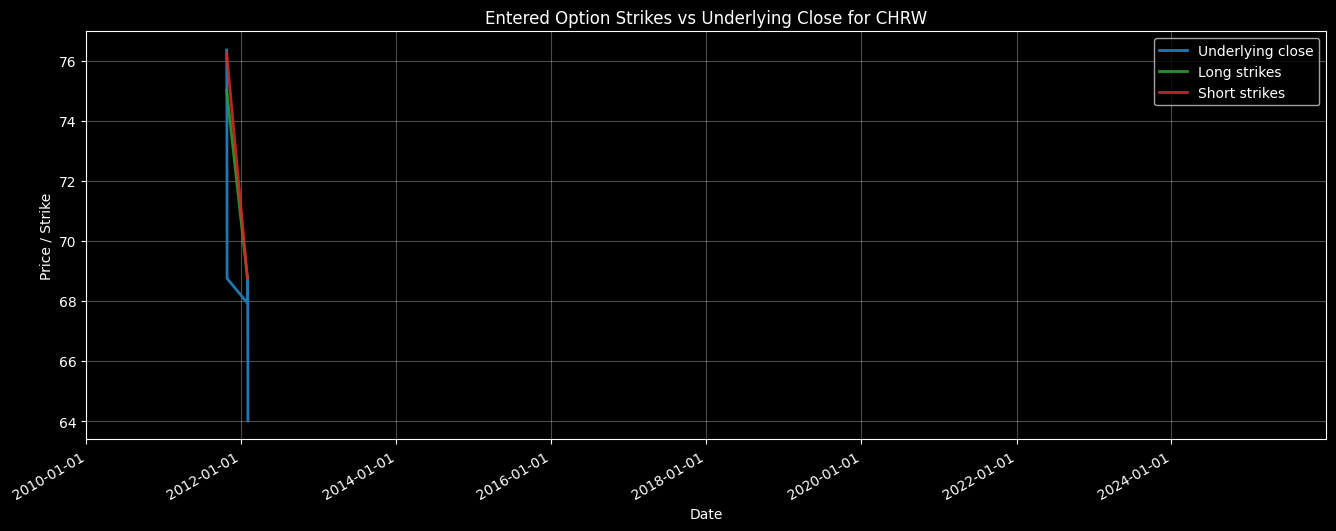

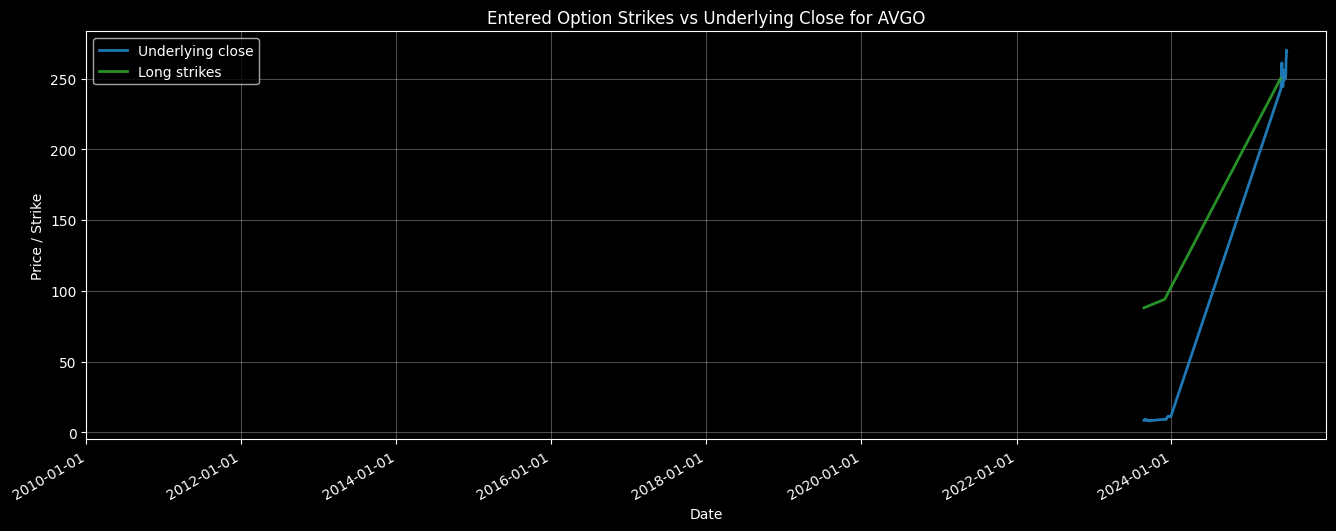

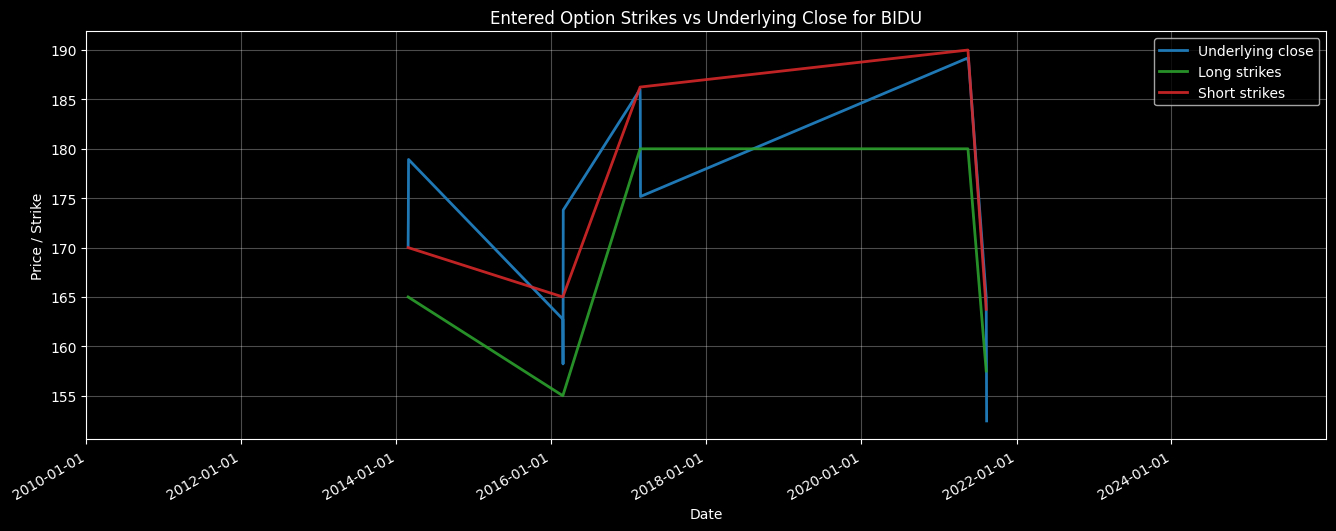

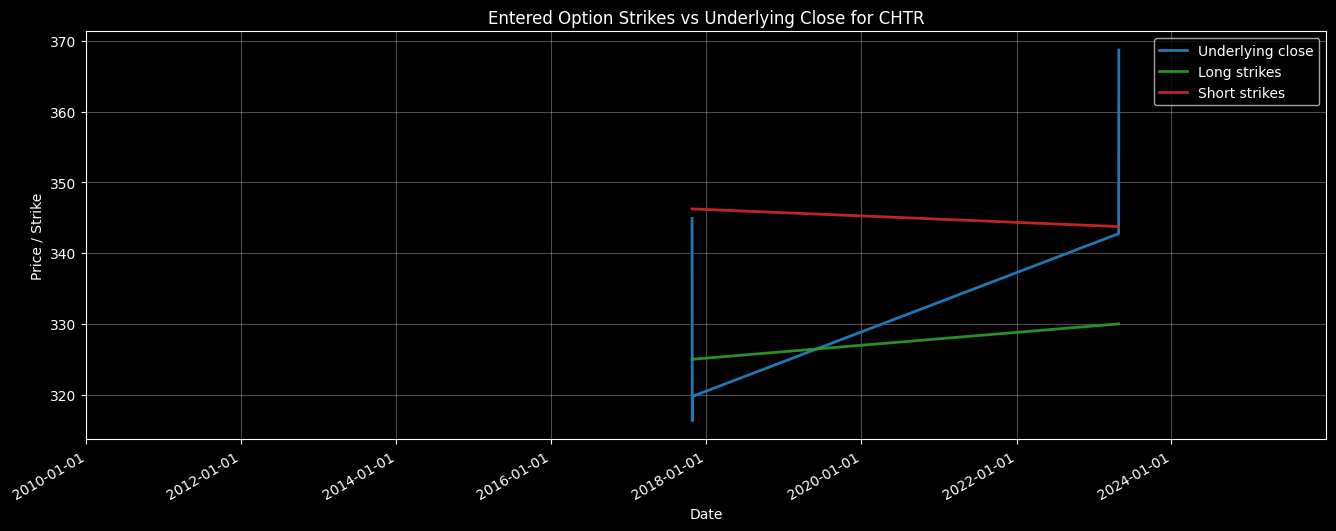

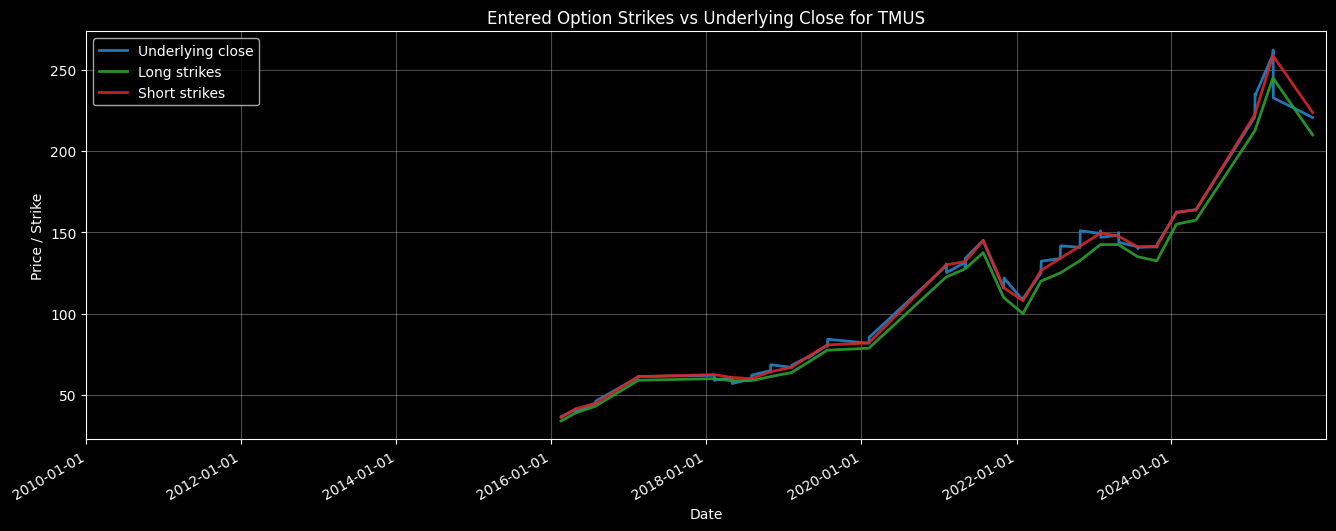

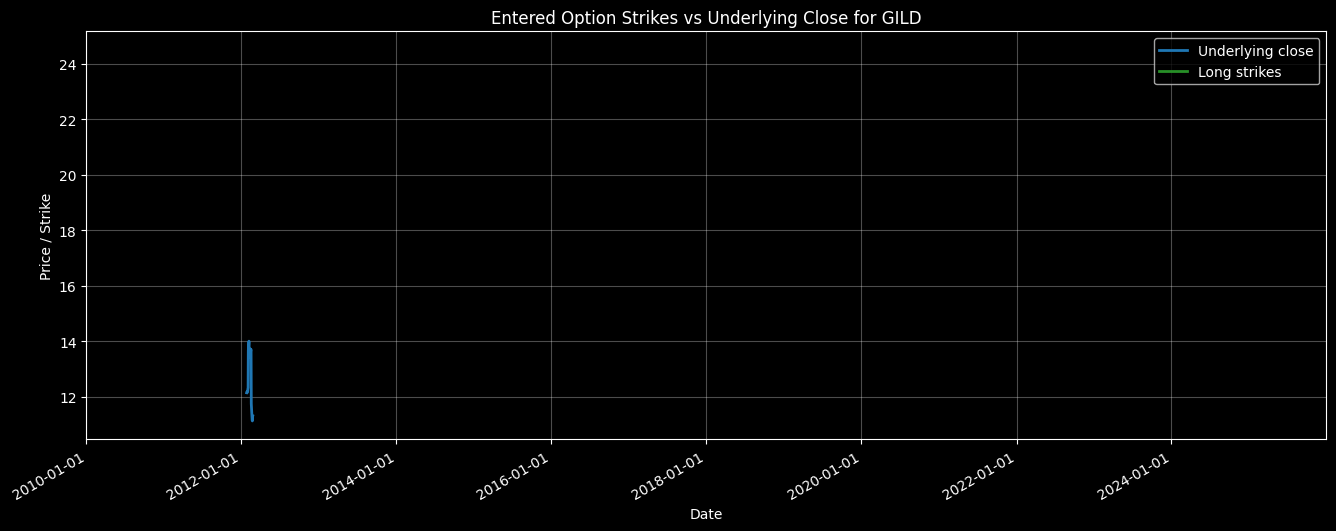

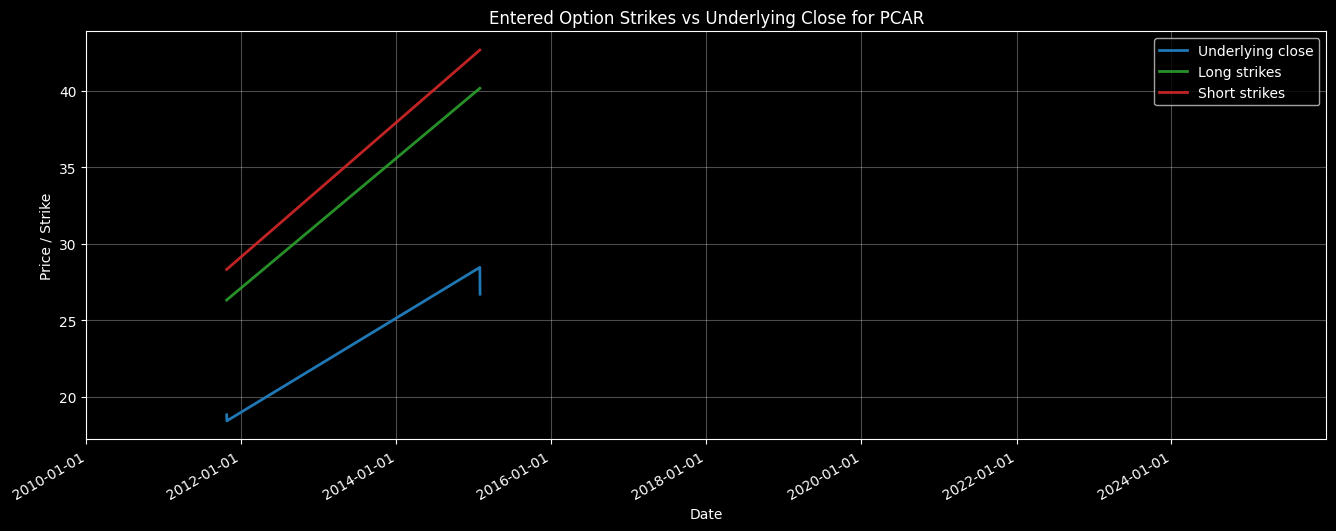

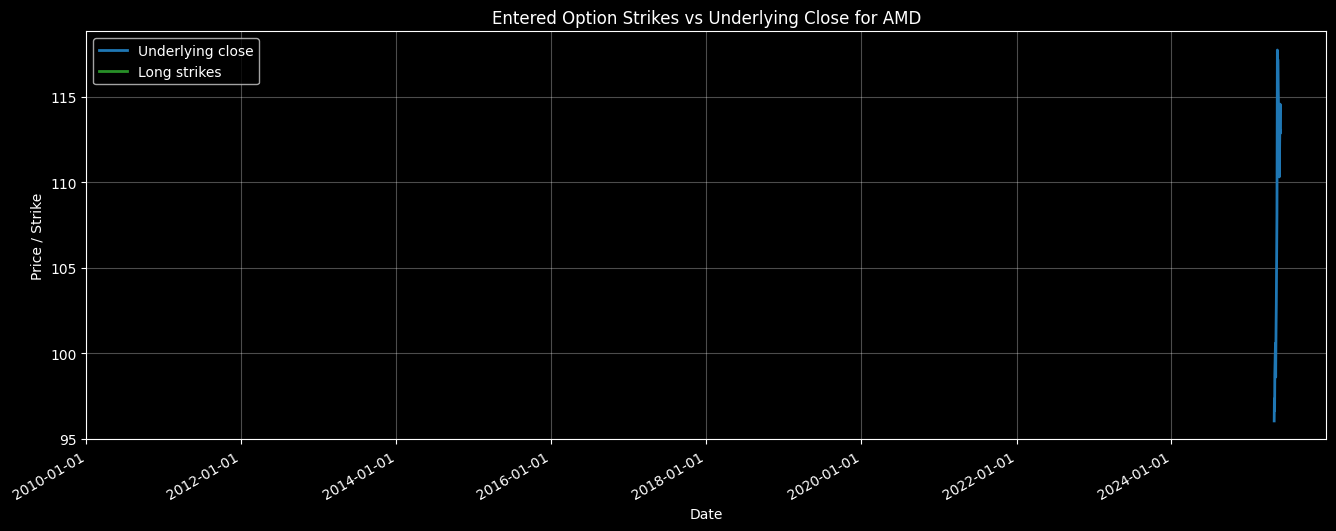

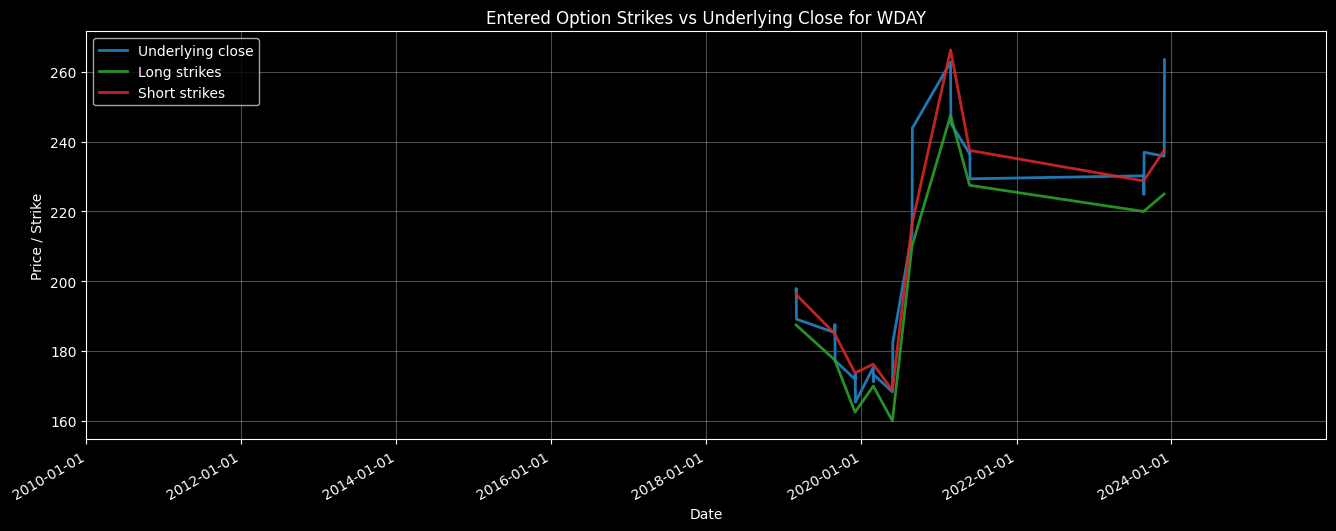

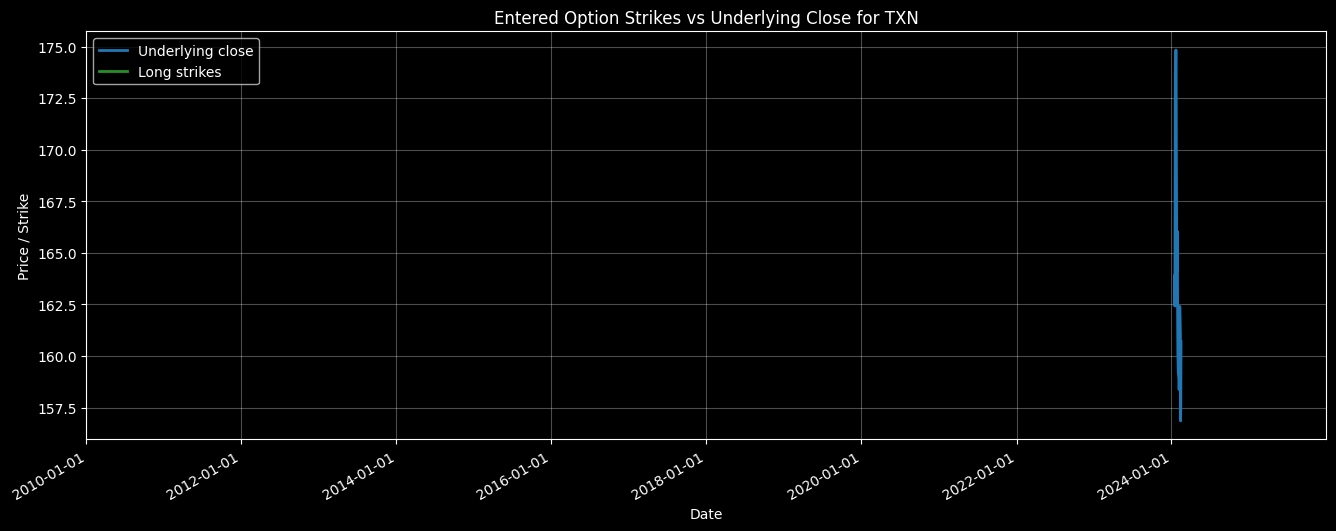

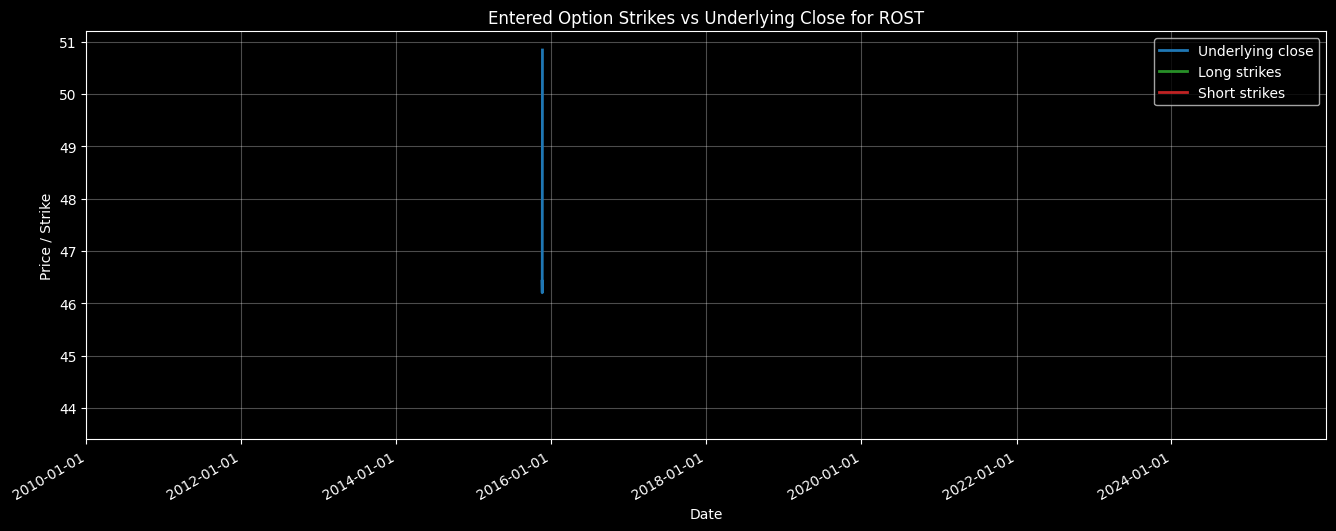

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotx 
import numpy as np
from statistics import mean

mpl.style.use("dark_background")

def plot_entry_strikes_lines(backtest_result, tick):
    """
    Plot entered option strikes over time as separate long/short lines,
    alongside the underlying close series. Returns (fig, ax).
    """
    trades = set()
    for snap in backtest_result.snapshots:
        trades.update(snap.trade_equities.keys())

    def norm_side(pos):
        if pos is None:
            return "unknown"
        if hasattr(pos, "value"):
            return str(pos.value).lower()
        s = str(pos).lower()
        if "long" in s:
            return "long"
        if "short" in s:
            return "short"
        return s

    long_strikes, short_strikes, underlying_series = {}, {}, {}

    for trade in trades:
        if trade._tick != tick:
            continue
        entry_date = trade.entry_data.entry_date
        px = trade.entry_data.price_series.get(entry_date)
        if px is None:
            continue

        side = norm_side(trade.entry_data.position_type)
        bucket = long_strikes if side == "long" else short_strikes
        bucket.setdefault(entry_date.to_datetime(), []).append(getattr(px, "strike", None))

        for _, contract_px in trade.entry_data.price_series.prices.items():
            u = getattr(contract_px, "underlying", None)
            if u is None or getattr(u, "date", None) is None:
                continue
            b, a = getattr(u, "bid", None), getattr(u, "ask", None)
            mid = (b + a) / 2 if b is not None and a is not None else b or a
            if mid is None:
                continue
            underlying_series[u.date.to_datetime()] = mid

    if not long_strikes and not short_strikes:
        return None, None
    
    def reduce_strikes(mapping):
        if not mapping:
            return [], []
        items = sorted(mapping.items(), key=lambda kv: kv[0])
        dates = [dt for dt, _ in items]
        strikes = [mean([s for s in vals if s is not None]) for _, vals in items]
        return dates, strikes

    long_dates, long_vals = reduce_strikes(long_strikes)
    short_dates, short_vals = reduce_strikes(short_strikes)

    fig, ax = plt.subplots(figsize=(16, 6))

    if underlying_series:
        u_dates, u_prices = zip(*sorted(underlying_series.items()))
        ax.plot(u_dates, u_prices, color="tab:blue", lw=2, label="Underlying close")

    if long_dates:
        ax.plot(long_dates, long_vals, color="tab:green", lw=2,
                label="Long strikes", alpha=0.9)
    if short_dates:
        ax.plot(short_dates, short_vals, color="tab:red", lw=2,
                label="Short strikes", alpha=0.9)

    ax.set_title(f"Entered Option Strikes vs Underlying Close for {tick}")
    ax.set_xlabel("Date")
    ax.set_xlim(start_date.to_datetime(), end_date.to_datetime())
    ax.set_ylabel("Price / Strike")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    fig.autofmt_xdate()
    ax.grid(True, alpha=0.3)
    ax.legend()
    return fig, ax

for tick in universe.ticks:
    fig, ax = plot_entry_strikes_lines(result, tick)

